# Data Details

Import the data from my Google Drive. The data consists of Indonesian seaweed farming Facebook posts from Rumput Laut Centre between 1 September 2021 and 29 August 2022.

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
from plotnine import *

drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/maddieFBdata.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


# Data Cleaning

In [2]:

# Add column for month
df['Month'] = df['Date'].apply(lambda x: x[x.find('-') + 1:] if '-' in x else x)

# Add column for year
is_2021 = (df['Month'] == "Sep") | (df['Month'] == "Oct") | (df['Month'] == "Nov") | (df['Month'] == "Dec")
df.loc[is_2021, 'Year'] = 2021
df.loc[~is_2021, 'Year'] = 2022
df['Year'] = df['Year'].astype(int)

# Removing all rows that say "Posted by..." because it is not helpful information
df = df[~df['English'].str.startswith("Posted by")]


Cleaning the English text in preparation for Latent Dirichlet Allocation (LDA).

In [3]:
import re
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer, PorterStemmer
import nltk

# Downloading NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

# Text Preprocessing function
def preprocess(text):
    # Convert to lowercase
    text = text.lower()

    # Expand contractions
    contractions = {
        "n't": "not",
        "'re": "are",
        "'s": "is",
        "'d": "would",
        "'ll": "will",
        "'t": "not",
        "'ve": "have",
        "'m": "am"
    }
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)

    # Remove URLs, mentions, and hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove short words
    text = re.sub(r'\b\w{1,2}\b', '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())

    return text

# Apply preprocessing to the DataFrame
df["original_English"] = df["English"] # while saving the original column for comparison
df['English'] = df['English'].apply(preprocess)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [4]:
# After preprocessing, there will be some empty entries

# Identify and replace empty strings or whitespace-only entries with NaN
df['English'].replace(to_replace=r'^\s*$', value=pd.NA, regex=True, inplace=True)

# Count empty entries before dropping
empty_entries_count = df['English'].isna().sum()
print(f"Number of empty entries after preprocessing: {empty_entries_count}")

# Remove empty entries
df.dropna(subset=['English'], inplace=True)


Number of empty entries after preprocessing: 101


# Incorporating weather data

Weather data is from: https://meteostat.net/en/place/id/makassar?s=97180&t=2022-08-04/2022-09-01 and has been downloaded into my Google Drive.

In [5]:
file_path_avgtemp = '/content/drive/MyDrive/temp_data_makassar.csv'
df_weather = pd.read_csv(file_path_avgtemp) # Where the data is located, and this url downloads this file. it imports the data

# Adjustment: Drop columns in the weather data frame without useful information
df_weather = df_weather.drop(columns=['snow', 'wpgt', 'tsun'])
df_weather

date  tavg  tmin  tmax  prcp  wdir  wspd    pres
0    2021-09-01  27.6  23.0  33.6   NaN   322   6.1  1009.3
1    2021-09-02  27.2  24.0  33.8   NaN   229   5.2  1009.1
2    2021-09-03  26.2  24.0  32.2   NaN    64   4.7  1009.1
3    2021-09-04  27.2  24.0  32.0   NaN   307   5.4  1009.4
4    2021-09-05  26.4  24.0  30.9   NaN    62   5.3  1010.4
..          ...   ...   ...   ...   ...   ...   ...     ...
358  2022-08-25  27.1  23.0  32.0   1.7   262   5.8  1009.2
359  2022-08-26  27.4  23.0  33.4   8.8   307   7.0  1008.3
360  2022-08-27  25.9  22.0  33.0   6.6   194   4.8  1008.2
361  2022-08-28  27.1  22.0  33.2   3.1   142   7.0  1008.0
362  2022-08-29  27.9  22.8  33.2   8.7   327   7.1  1008.3

[363 rows x 8 columns]

In [6]:
# Preparing and merging the dataframes
from datetime import datetime

# Dictionary to map month names to integer values
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Map month names to integers
df['Month'] = df['Date'].str.split('-').str[1]
df['Month'] = df['Month'].map(month_mapping)

# Combine the Day, Month, and Year columns into a single datetime column
df['date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['Date'].str.split('-').str[0])
df['date'] = df['date'].astype("string") # Make into string
df_weather['date'] = df_weather['date'].astype("string") # Make into string

# Merge the DataFrames on the 'date' column
joined_df = df.merge(df_weather, on=["date"], how="left")
joined_df = joined_df.drop(columns=['Date'])

# The given dataset has a "Category" column, but I will be finding my own categories
joined_df = joined_df.drop(columns=['Category'])

# MY DATASET!
joined_df

Bahasa  \
0     Bismillah ... !! Lagi cari rumput laut catoni ...   
1     Cari budidaya rumput laut cottonii. DAERAH BAL...   
2     Putih kapur sirih yuk kering kawat wa 08228225...   
3           Sapa tw ada yang minat Pukat Rumput 19 utas   
4     Membutuhkan RL Sargassum dalam jumlah besar un...   
...                                                 ...   
4312  Siapa tau ada yang minat mesin gantung 40 pk a...   
4313  Proses Pengiriman Yaa Bossku Jeneponto Tarowan...   
4314  Sekitar 1ton Katonik cocok harga angkut... Pin...   
4315  Maaf numpang lapak min.. Smpt ada yg minat bua...   
4316  Lagi cari bayer buat angkut rumput laut di dae...   

                                                English  Month  Year  \
0      bismillah looking seaweed catoni wilaya sulawesi      9  2021   
1     look cottonii seaweed cultivation balikpapan a...      9  2021   
2     white whiting letis dry wire location south la...      9  2021   
3             know anyone interested thread grass trawl      9  2021   
4     requires large quantity sargassum delivery sur...      9  2021   
...                                                 ...    ...   ...   
4312  know anyone interested hanging machine address...      8  2022   
4313  delivery process yes bos jeneponto tarowang bo...      8  2022   
4314  ton catonic fit price transportation pinrang s...      8  2022   
4315  sorry ride stall min someone interested transp...      8  2022   
4316  looking bayer transport seaweed maluku area ne...      8  2022   

                                       original_English        date  tavg  \
0     Bismillah...!! Looking for seaweed catoni wila...  2021-09-06  26.7   
1     Look for cottonii seaweed cultivation. BALIKPA...  2021-09-06  26.7   
2     White whiting let's dry the wire wa 0822822505...  2021-09-06  26.7   
3     Who knows, anyone is interested in 19 threads ...  2021-09-06  26.7   
4     Requires large quantities of RL Sargassum for ...  2021-09-11  26.3   
...                                                 ...         ...   ...   
4312  Who knows if anyone is interested in a 40 pk h...  2022-08-31   NaN   
4313  Delivery Process Yes, my boss Jeneponto Tarowa...  2022-08-07  26.0   
4314  About 1 ton of catonic fits the price of trans...  2022-08-11  26.8   
4315  Sorry to ride in the stall, min.. Until someon...  2022-08-22  27.2   
4316  Looking for a Bayer to transport seaweed in th...  2022-08-27  25.9   

      tmin  tmax  prcp   wdir  wspd    pres  
0     25.0  32.7   NaN  139.0   5.6  1010.7  
1     25.0  32.7   NaN  139.0   5.6  1010.7  
2     25.0  32.7   NaN  139.0   5.6  1010.7  
3     25.0  32.7   NaN  139.0   5.6  1010.7  
4     24.0  32.0   NaN  192.0   5.7  1009.4  
...    ...   ...   ...    ...   ...     ...  
4312   NaN   NaN   NaN    NaN   NaN     NaN  
4313  23.0  31.8   0.0  145.0   5.6  1009.5  
4314  24.0  31.2   7.1   60.0   7.4  1009.7  
4315  21.0  33.6   0.1  100.0   6.4  1009.3  
4316  22.0  33.0   6.6  194.0   4.8  1008.2  

[4317 rows x 13 columns]

# Unsupervised clustering on the text

In this section, I will perform LDA (unsupervised clustering) on the English text in my dataframe.

After creating the clusters and naming the clusters, I will also map the clusters with other factors such as date, month, average temperature, and precipitation to see if any clusters seem to be related to these factors-- for instance, if are more posts about selling and buying seaweed when precipitation is low (as current literature suggests that seaweed farming is more productive during the dry season). Ultimately, I did not find any patterns between any weather variables and seaweed Facebook post clusters.

In [9]:
# LDA!
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.90, min_df=5)
X_tfidf = vectorizer.fit_transform(joined_df['English'])

# LDA Topic Modeling
n_topics = 7 # proved to have the highest f1_macro score (gridsearchCV was used to optimize this parameter)
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, doc_topic_prior=0.5, topic_word_prior=0.5)
lda.fit(X_tfidf)

# Display LDA topics
def display_topics(model, feature_names, n_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topics.append(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    return topics

n_top_words = 10
tf_feature_names = vectorizer.get_feature_names_out()
topics = display_topics(lda, tf_feature_names, n_top_words)

# printing words associated with each cluster to understand common topics in each cluster
for idx, topic in enumerate(topics):
    print(f"Topic {idx}: {topic}")

""" code to see some sample posts for each topic, so I can make my own topic names """
# Get the topic distribution for each document
topic_distributions = lda.transform(X_tfidf)

# Assign the most probable topic to each document
joined_df['assigned_topic'] = topic_distributions.argmax(axis=1)

# Function to display 10 sample posts for each topic
def display_sample_documents_per_topic(df, topic_column, text_column, n_samples=10):
    for topic in df[topic_column].unique():
        print(f"\nTopic {topic}:")
        sample_docs = df[df[topic_column] == topic].sample(n=min(n_samples, len(df[df[topic_column] == topic])), random_state=42)
        for doc in sample_docs[text_column]:
            print(f"- {doc}")

# Display a sample of documents for each topic
display_sample_documents_per_topic(joined_df, 'assigned_topic', 'English', n_samples=10)

"""====================================="""

# # Creating topic names
# topic_names = ["Local Updates", "Seaweed Information", "Buying and Selling Seaweed", "Land and Foundation Sales", "Supply and Demand for Seaweed", "Community Engagement", "Nursery and Cultivation Practices"]

# # Map topic numbers to topic names
# joined_df['assigned_topic_name'] = joined_df['assigned_topic'].map(lambda x: topic_names[x])

# Topic names mapping based on the provided order
topic_mapping = {
    4: "Local Updates",
    6: "Seaweed Information",
    0: "Buying and Selling Seaweed",
    2: "Land and Foundation Sales",
    5: "Supply and Demand for Seaweed",
    1: "Community Engagement",
    3: "Nursery and Cultivation Practices"
}

# Map topic numbers to topic names
joined_df['assigned_topic_name'] = joined_df['assigned_topic'].map(topic_mapping)


Topic 0: alhamdulillah day itis much sulawesi south interested south sulawesi still god
Topic 1: price check check price seaweed area seed info grass price seaweed wajo
Topic 2: sell tarakan anyone want bulukumba jeneponto area someone want sell east
Topic 3: bos interested foundation location contact sale bone north buy million
Topic 4: ready seaweed need cottoni please looking ton know type sebatik
Topic 5: greeting rope one nunukan greeting one catonic one rope greeting one rope bos luwu
Topic 6: nursery good sargassum mamolo morning seaweed interest iam cultivation afternoon

Topic 4:
- lot stock
- bismillah looking buyer dried gracilaria seaweed moisture content press information please call
- need dry seaweed ready wholesale ready pick location
- bayer work
- know someone need red seed
- ready pick catoniis parent
- looking canttoni type seaweed sent south sulawesi call number
- need ton cottoni seaweed area east java bali lombok pay direct factory note inbox
- looking dried seaw

# Assessing the quality of clusters

In the code below I build a K-nearest classifier model to try and assess how good the clusters are. The intuition is that the K-nearest classifier model will learn the clusters I created in the code above and then try to predict the correct category (e.g. Selling and Buying Seaweed, Land and Foundation Sales, etc) for different sets of posts (cross validation). The better that this K-nearest classifier model is able to predict the correct category, the more well-defined my clusters are.

I chose the f1_macro metric to balance an incorporation of precision and recall. The resulting cross-validated f1_macro score was 0.6.

I then use a confusion matrix to display which categories were commonly mis-categorized as each other.

Cross-validation F1 macro score: 0.6031249155343673
                                   precision    recall  f1-score   support

                    Local Updates       0.38      0.91      0.53       173
              Seaweed Information       0.71      0.65      0.68       118
       Buying and Selling Seaweed       0.71      0.55      0.62       100
        Land and Foundation Sales       0.84      0.42      0.56       151
    Supply and Demand for Seaweed       0.86      0.53      0.65       118
             Community Engagement       0.92      0.41      0.57       109
Nursery and Cultivation Practices       0.89      0.59      0.71        95

                         accuracy                           0.60       864
                        macro avg       0.76      0.58      0.62       864
                     weighted avg       0.73      0.60      0.61       864



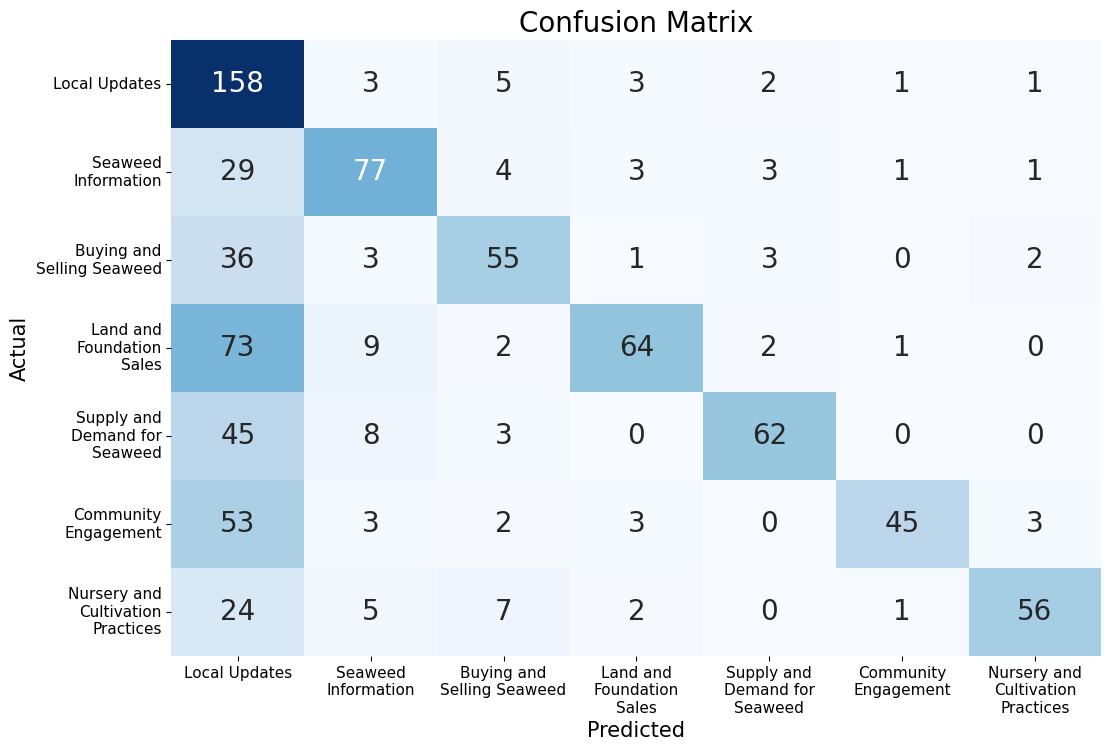

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap


""" Creating the KNClassifier Model
------------------------------------"""

# Prepare the data for model
X = joined_df[["English"]]
y = joined_df['assigned_topic_name']

# Create a column transformer and pipeline
ct = make_column_transformer(
    (TfidfVectorizer(ngram_range=(1, 3), max_df=0.90, min_df=5), 'English'),
    remainder="drop"
)

pipeline = make_pipeline(
    ct,
    KNeighborsClassifier(n_neighbors=3, metric="euclidean")
)

# Cross-validation score
cv_score = cross_val_score(
    pipeline,
    X=X,
    y=y,
    scoring="f1_macro",  # or "accuracy" if you prefer
    cv=10
).mean()

print(f'Cross-validation F1 macro score: {cv_score}')


""" Creating a classification report
-------------------------------------"""

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Fit KNN classifier
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=topic_mapping.values()))

""" Making a confusion matrix to illustrate which clusters are most similar
to each other or commonly mis-categorized as each other
------------------------------------------------------------- """

# Confusion matrix
unique_labels = sorted(y.unique())
label_names = [topic_mapping[key] for key in topic_mapping if topic_mapping[key] in unique_labels]

conf_matrix = confusion_matrix(y_test, y_pred, labels=unique_labels)
conf_matrix_df = pd.DataFrame(conf_matrix, index=label_names, columns=label_names)

# Plot confusion matrix <-- would be better to do an "average" confusion matrix using many different sets of test and train data!!!
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 20})

# Adjust x-axis and y-axis labels to be at the center of each box
wrapped_labels = [textwrap.fill(label, 15) for label in label_names]  # Wrap labels to 15 characters per line
plt.xticks(ticks=np.arange(len(label_names)) + 0.5, labels=wrapped_labels, rotation=0, ha='center', fontsize=11)
plt.yticks(ticks=np.arange(len(label_names)) + 0.5, labels=wrapped_labels, rotation=0, fontsize=11)

plt.ylabel('Actual', fontsize=15)
plt.xlabel('Predicted', fontsize=15)
plt.title('Confusion Matrix', fontsize=20)
plt.show()


In [11]:
# Set pandas options to display longer text entries without truncating
pd.set_option('display.max_colwidth', None)

is_localupdates = (joined_df["assigned_topic_name"] == "Local Updates")
is_seaweedpriceinfo = (joined_df["assigned_topic_name"] == "Seaweed Information")
is_buysell = (joined_df["assigned_topic_name"] == "Buying and Selling Seaweed")
is_nursery = (joined_df["assigned_topic_name"] == "Nursery and Cultivation Practices")
is_comm = (joined_df["assigned_topic_name"] == "Community Engagement")

joined_df[is_comm].head(20)

Bahasa  \
15                                                                                                                                     Ijin Assalamualaikum Wr Wb   
19                                                                                                                    Info penampung rumput laut area jabodetabek   
31                                                                                      Cek harga sp, di daerah masing2. HARGA *sp basah....... *sp kering.......   
35                                                                                                                     Rumput laut hasil AndulunG,, ,harga 12000$   
54                                                                                                                Jeneponto, bagian pesisir semangatki truess....   
62                                                                                                                                        Penrang wajo, dsni lagi   
69                                                                                                                     Cek harga RP kering cottoni area jeneponto   
76                                     Assalamualaikum ada yang jual tepung rumput laut cottanik area Makassar, kalau ada info secepatnya buat bahan penelitian 🙏   
83                                                                                                                  butuh bibit rumput laut persiapan musin hujan   
90                                                                                          MAU CARI BIBIT DAERAH KERTASARI SUMBAWA..Tlong japri..082 340 951 606   
92                                                  Assalamu'alaikum Wr. Wb Infokan Semua Harga Rumput Laut di Daerahnya Masing2 yah.. Catannya tulis Di Komentar   
94                                                                                                       Cek Dulu Hrg Rumput Laut Didaerahta Masing - Masing. . .   
100                                          Assalamualaikum,, Adakah yg menyediakan bibit rumput laut ?sy butuh,,tp sy d Sulawesi tengah,Banggai Kepulauan.info!   
103  Assalamualaikum sempat disini teman2 ada yang mau beli perahu lanra banynyara keluarga nya atau sekampungnya bisaka ki hubungi 🙏085810852446 daerah bantaeng   
106                                                                                                                                    ngebibit lagi #bersyukur 😇   
117                                                                                                                                           Tabe' cek harga dlu   
125                                                                                                                            Ditempat sya jg bnyak agar bossku.   
131                                                                                                                                           Persiapan bibit....   
135                                                                                                                                      Sp harga berapa sekarang   
141                                                                                                                 Rumput laut batu Cek harga nya para senior2ku   

                                                                                                             English  \
15                                                                                                   assalamualaikum   
19                                                                           seaweed container info jabodetabek area   
31                                                                                    check price area price wet dry   
35                                                                                           andulunis seaweed price   
54                                                                                jenepon

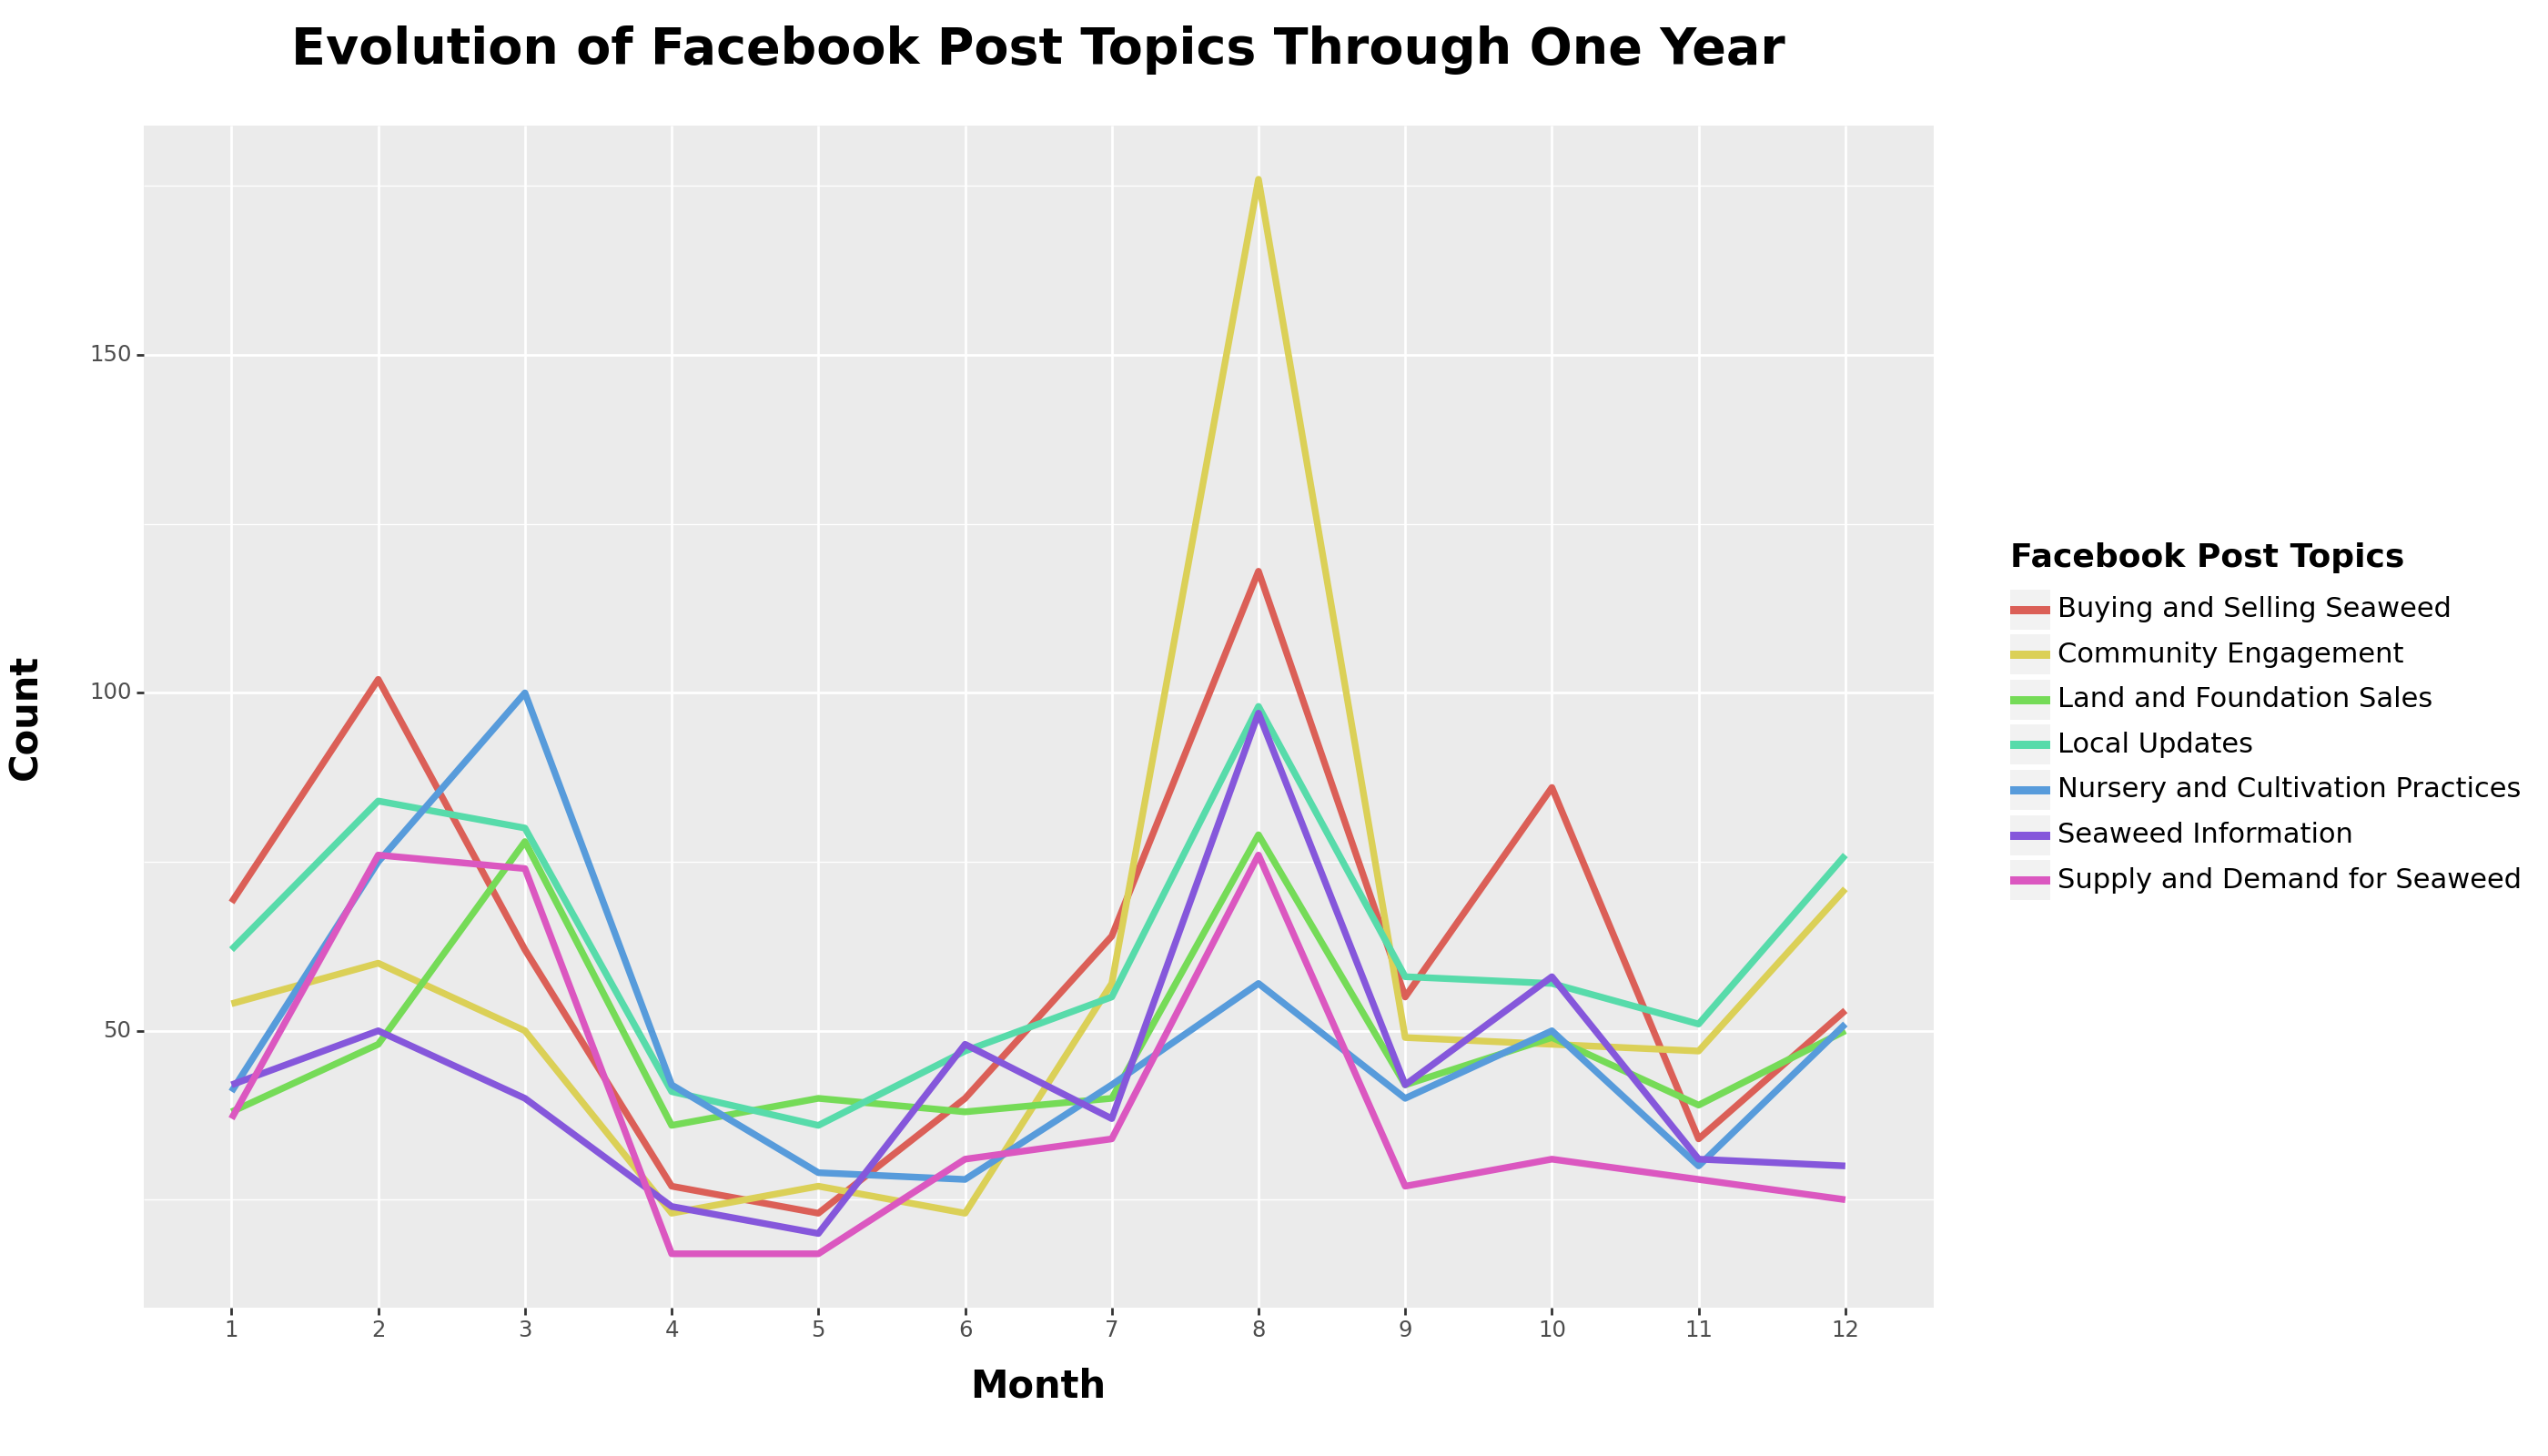

In [12]:

from plotnine import *
from mizani.formatters import date_format

# Ensure Month is treated as a categorical variable
joined_df["Month"] = joined_df["Month"].astype("category")

# Create the line plot with thicker lines and shaded area below
plot = (ggplot(joined_df, aes(x='Month', color='assigned_topic_name', group='assigned_topic_name'))
        + geom_line(stat='count', size=1.5)  # Adjust size for thicker lines
        + labs(color='Facebook Post Topics', x='Month', y='Count', fill='Facebook Post Topics', title="Evolution of Facebook Post Topics Through One Year")
        + theme_gray()
        + theme(
            figure_size=(14, 8),  # Adjust figure size (width, height)
            plot_title=element_text(hjust=0.5, size=20, weight='bold'),  # Center and adjust the title
            axis_title_x=element_text(size=15, weight='bold', hjust=0.5),  # Adjust x-axis label
            axis_title_y=element_text(size=15, weight='bold', hjust=0.5),  # Adjust y-axis label
            legend_title=element_text(size=13, weight='bold'),  # Adjust legend title
            legend_text=element_text(size=11)  # Adjust legend text size
        ))

print(plot)


# Creating graphs of the relationship between the number of posts in each cluster and climate-related variables

Graph of clusters vs precipitation

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 3080 rows containing non-finite values.


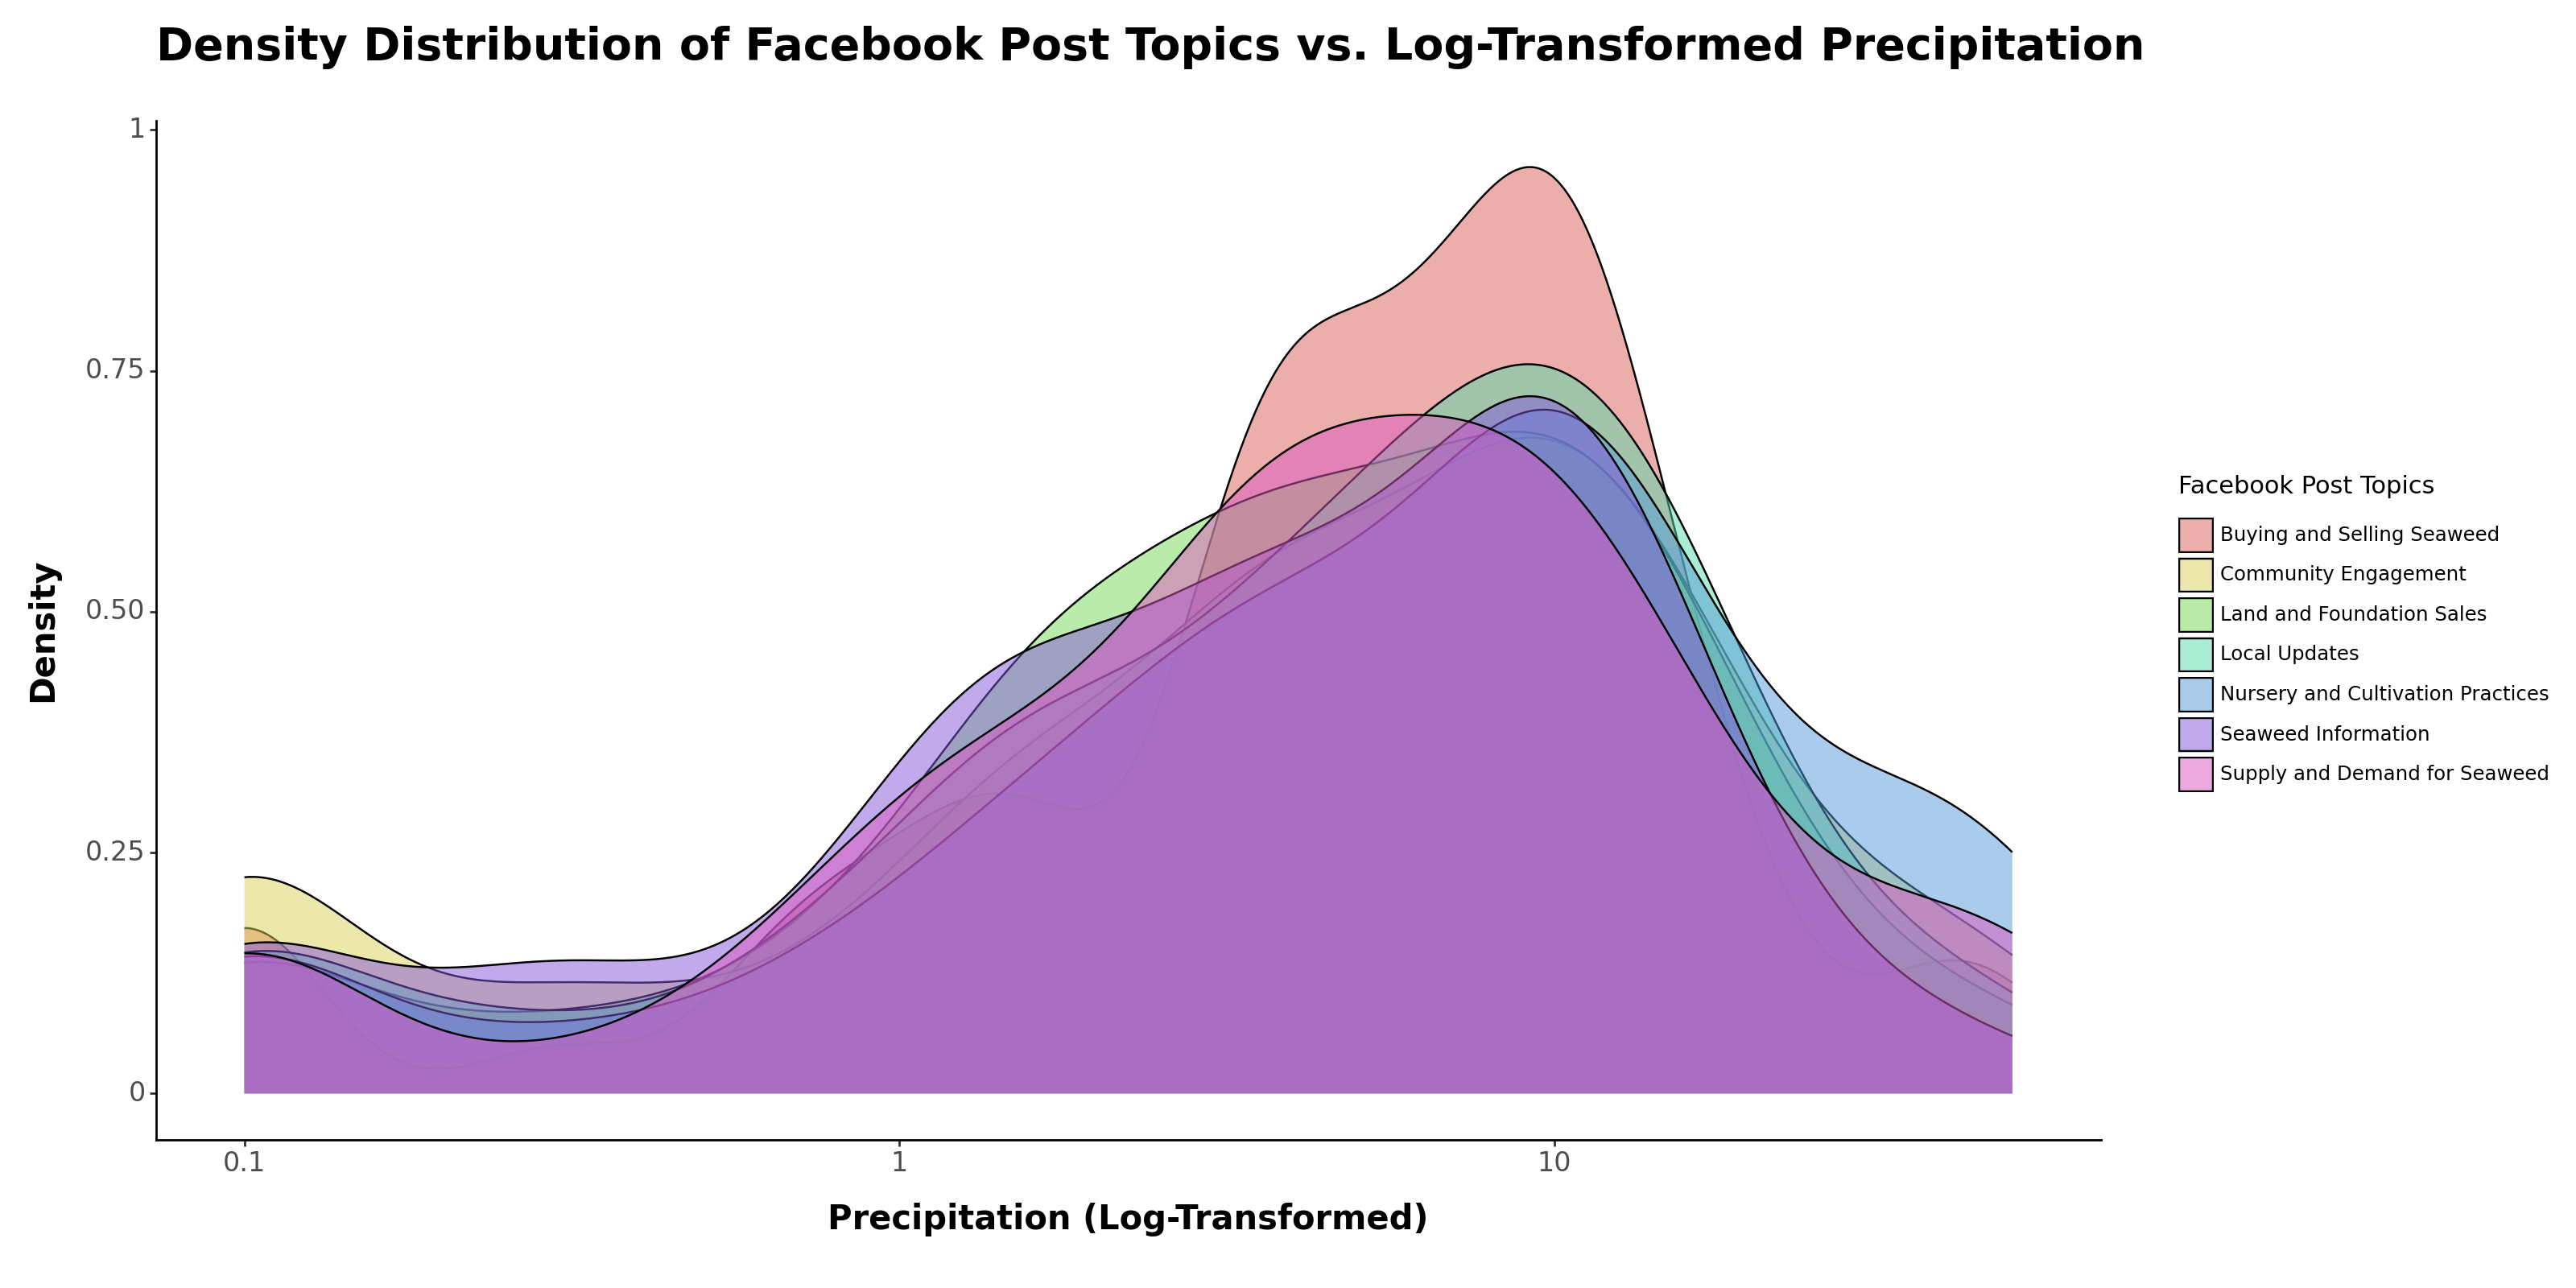

In [13]:

# Ensure Month is treated as an integer variable
joined_df["Month"] = joined_df["Month"].astype("int")


# Create the density plot with log-transformed x-axis
plot = (ggplot(joined_df, aes(x='prcp', fill='assigned_topic_name'))
        + geom_density(alpha=0.5)
        + labs(x="Precipitation (Log-Transformed)", y="Density", title="Density Distribution of Facebook Post Topics vs. Log-Transformed Precipitation", fill='Facebook Post Topics')
        + scale_x_log10()  # Apply log10 transformation to x-axis
        + theme_classic()
        + theme(
            figure_size=(16, 8),  # Make the figure longer horizontally
            plot_title=element_text(size=20, weight='bold'),  # Adjust the title font size and boldness
            axis_title_x=element_text(size=15, weight='bold'),  # Adjust x-axis label font size and boldness
            axis_title_y=element_text(size=15, weight='bold'),  # Adjust y-axis label font size and boldness
            axis_text_x=element_text(size=12),  # Adjust x-axis ticks font size
            axis_text_y=element_text(size=12)   # Adjust y-axis ticks font size
        ))

print(plot)


Graph of clusters vs average temperature

/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 29 rows containing non-finite values.


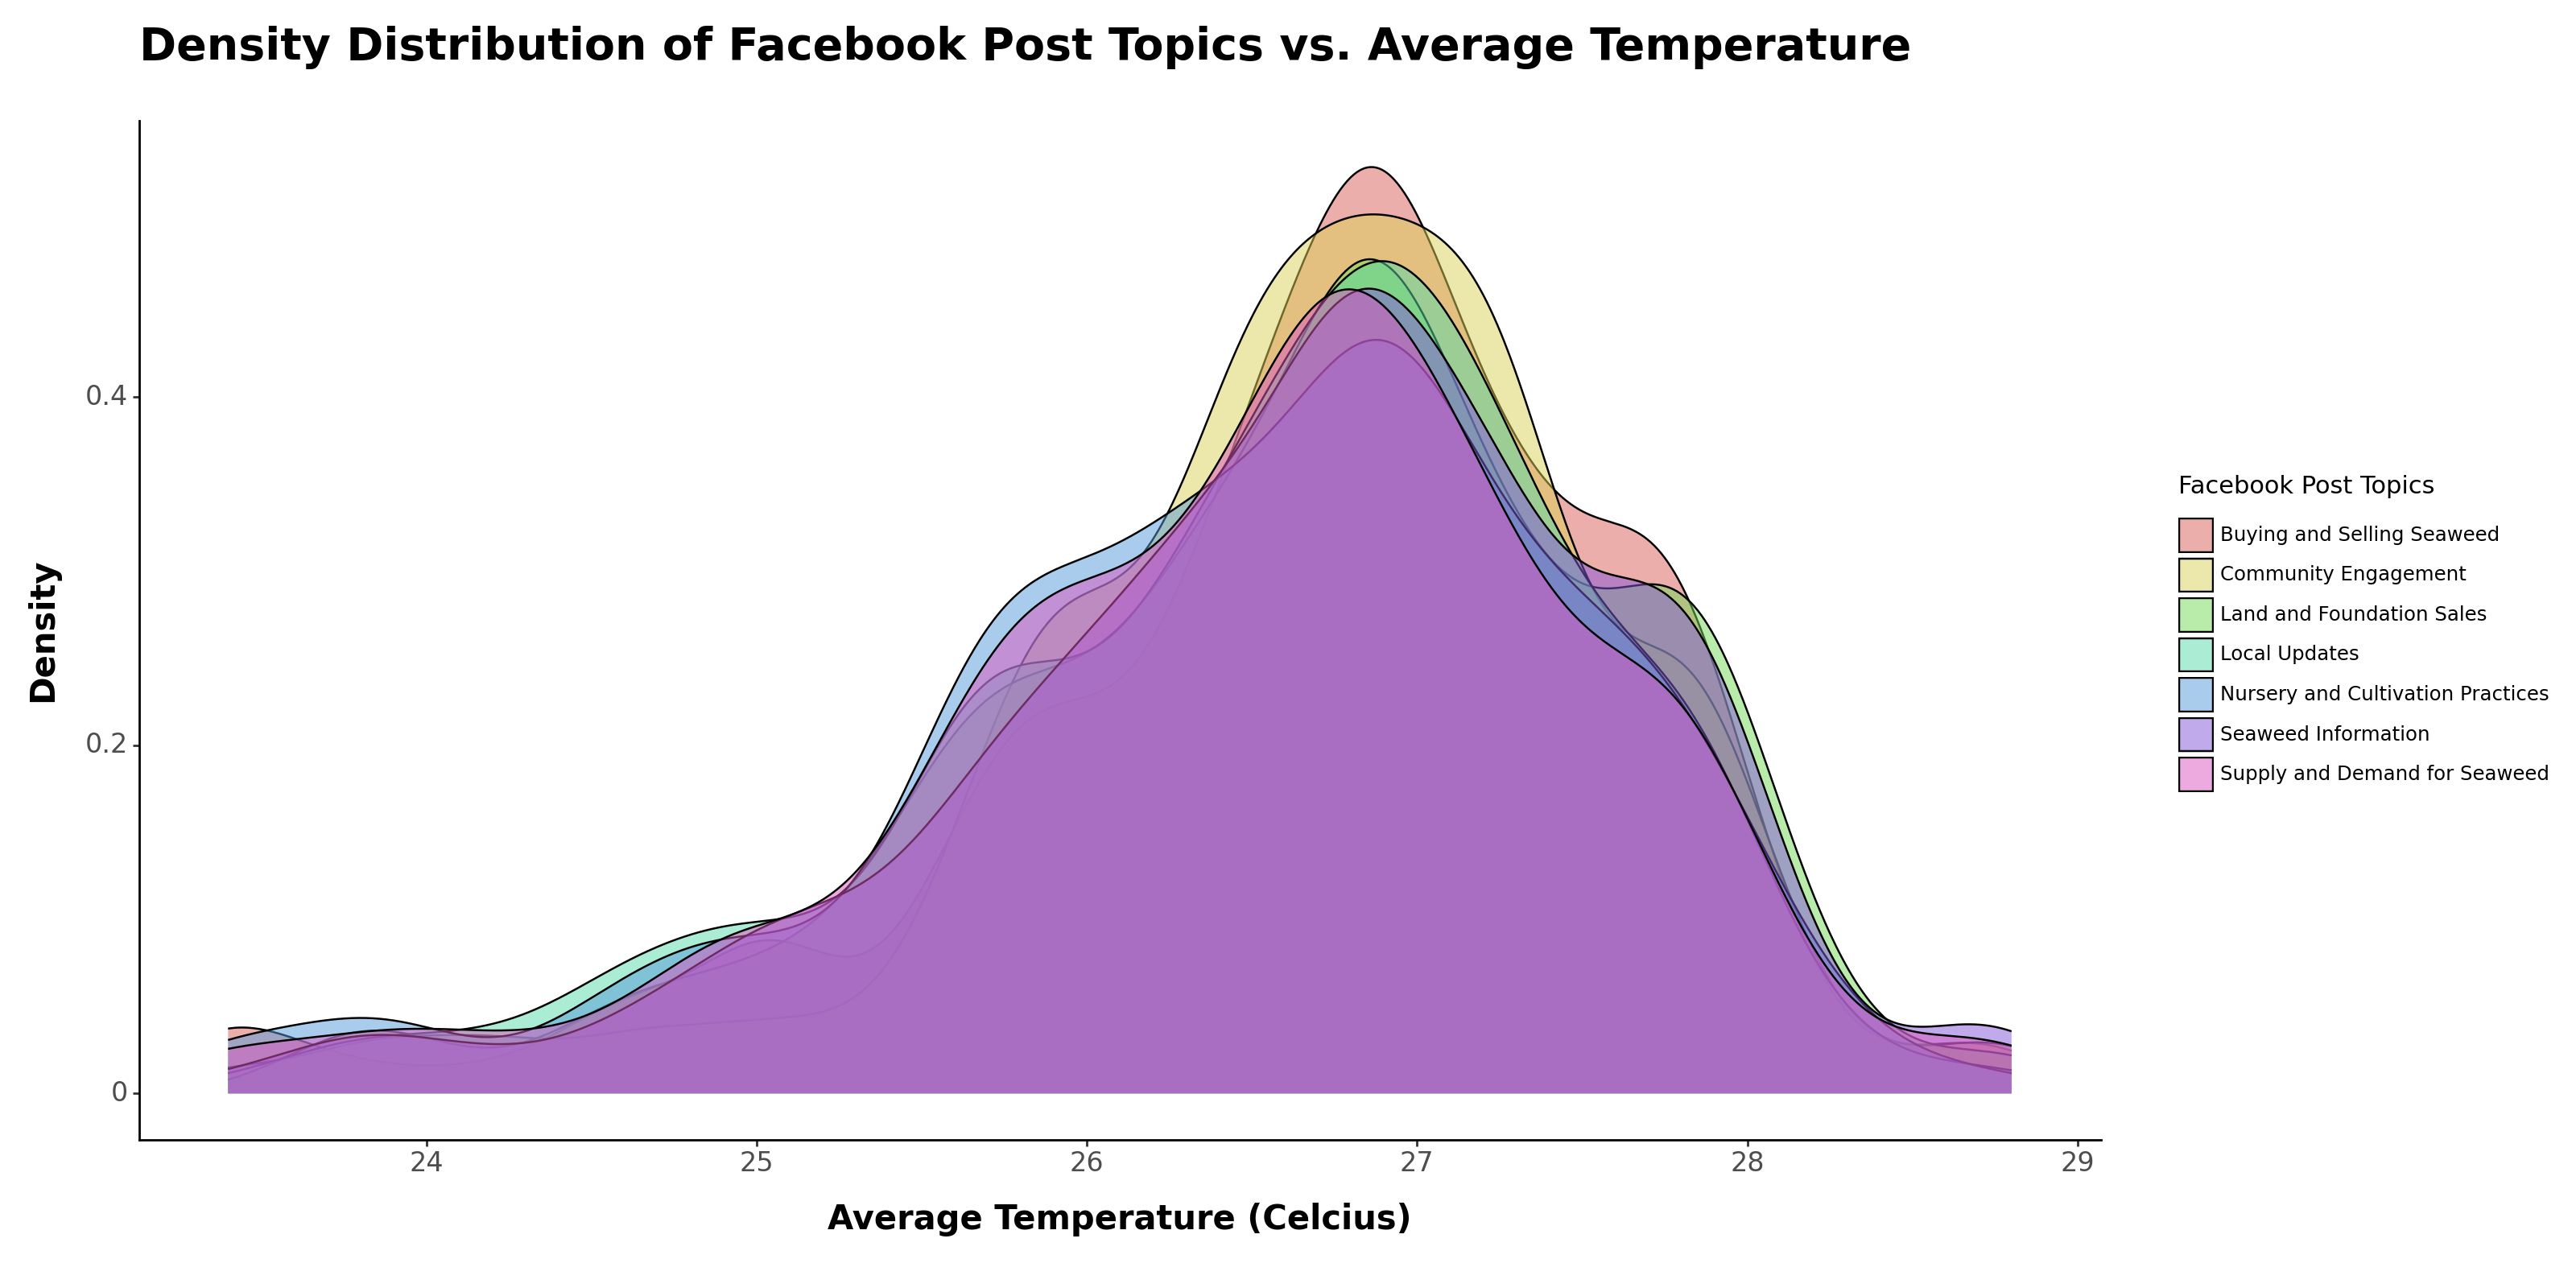

In [14]:


# Create the density plot with log-transformed x-axis
plot = (ggplot(joined_df, aes(x='tavg', fill='assigned_topic_name'))
        + geom_density(alpha=0.5)
        + labs(x="Average Temperature (Celcius)", y="Density", title="Density Distribution of Facebook Post Topics vs. Average Temperature", fill='Facebook Post Topics')
        # + scale_x_log10()  # Apply log10 transformation to x-axis
        + theme_classic()
        + theme(
            figure_size=(16, 8),  # Make the figure longer horizontally
            plot_title=element_text(size=20, weight='bold'),  # Adjust the title font size and boldness
            axis_title_x=element_text(size=15, weight='bold'),  # Adjust x-axis label font size and boldness
            axis_title_y=element_text(size=15, weight='bold'),  # Adjust y-axis label font size and boldness
            axis_text_x=element_text(size=12),  # Adjust x-axis ticks font size
            axis_text_y=element_text(size=12)   # Adjust y-axis ticks font size
        ))

print(plot)

Graph of clusters vs wind direction

/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 29 rows containing non-finite values.


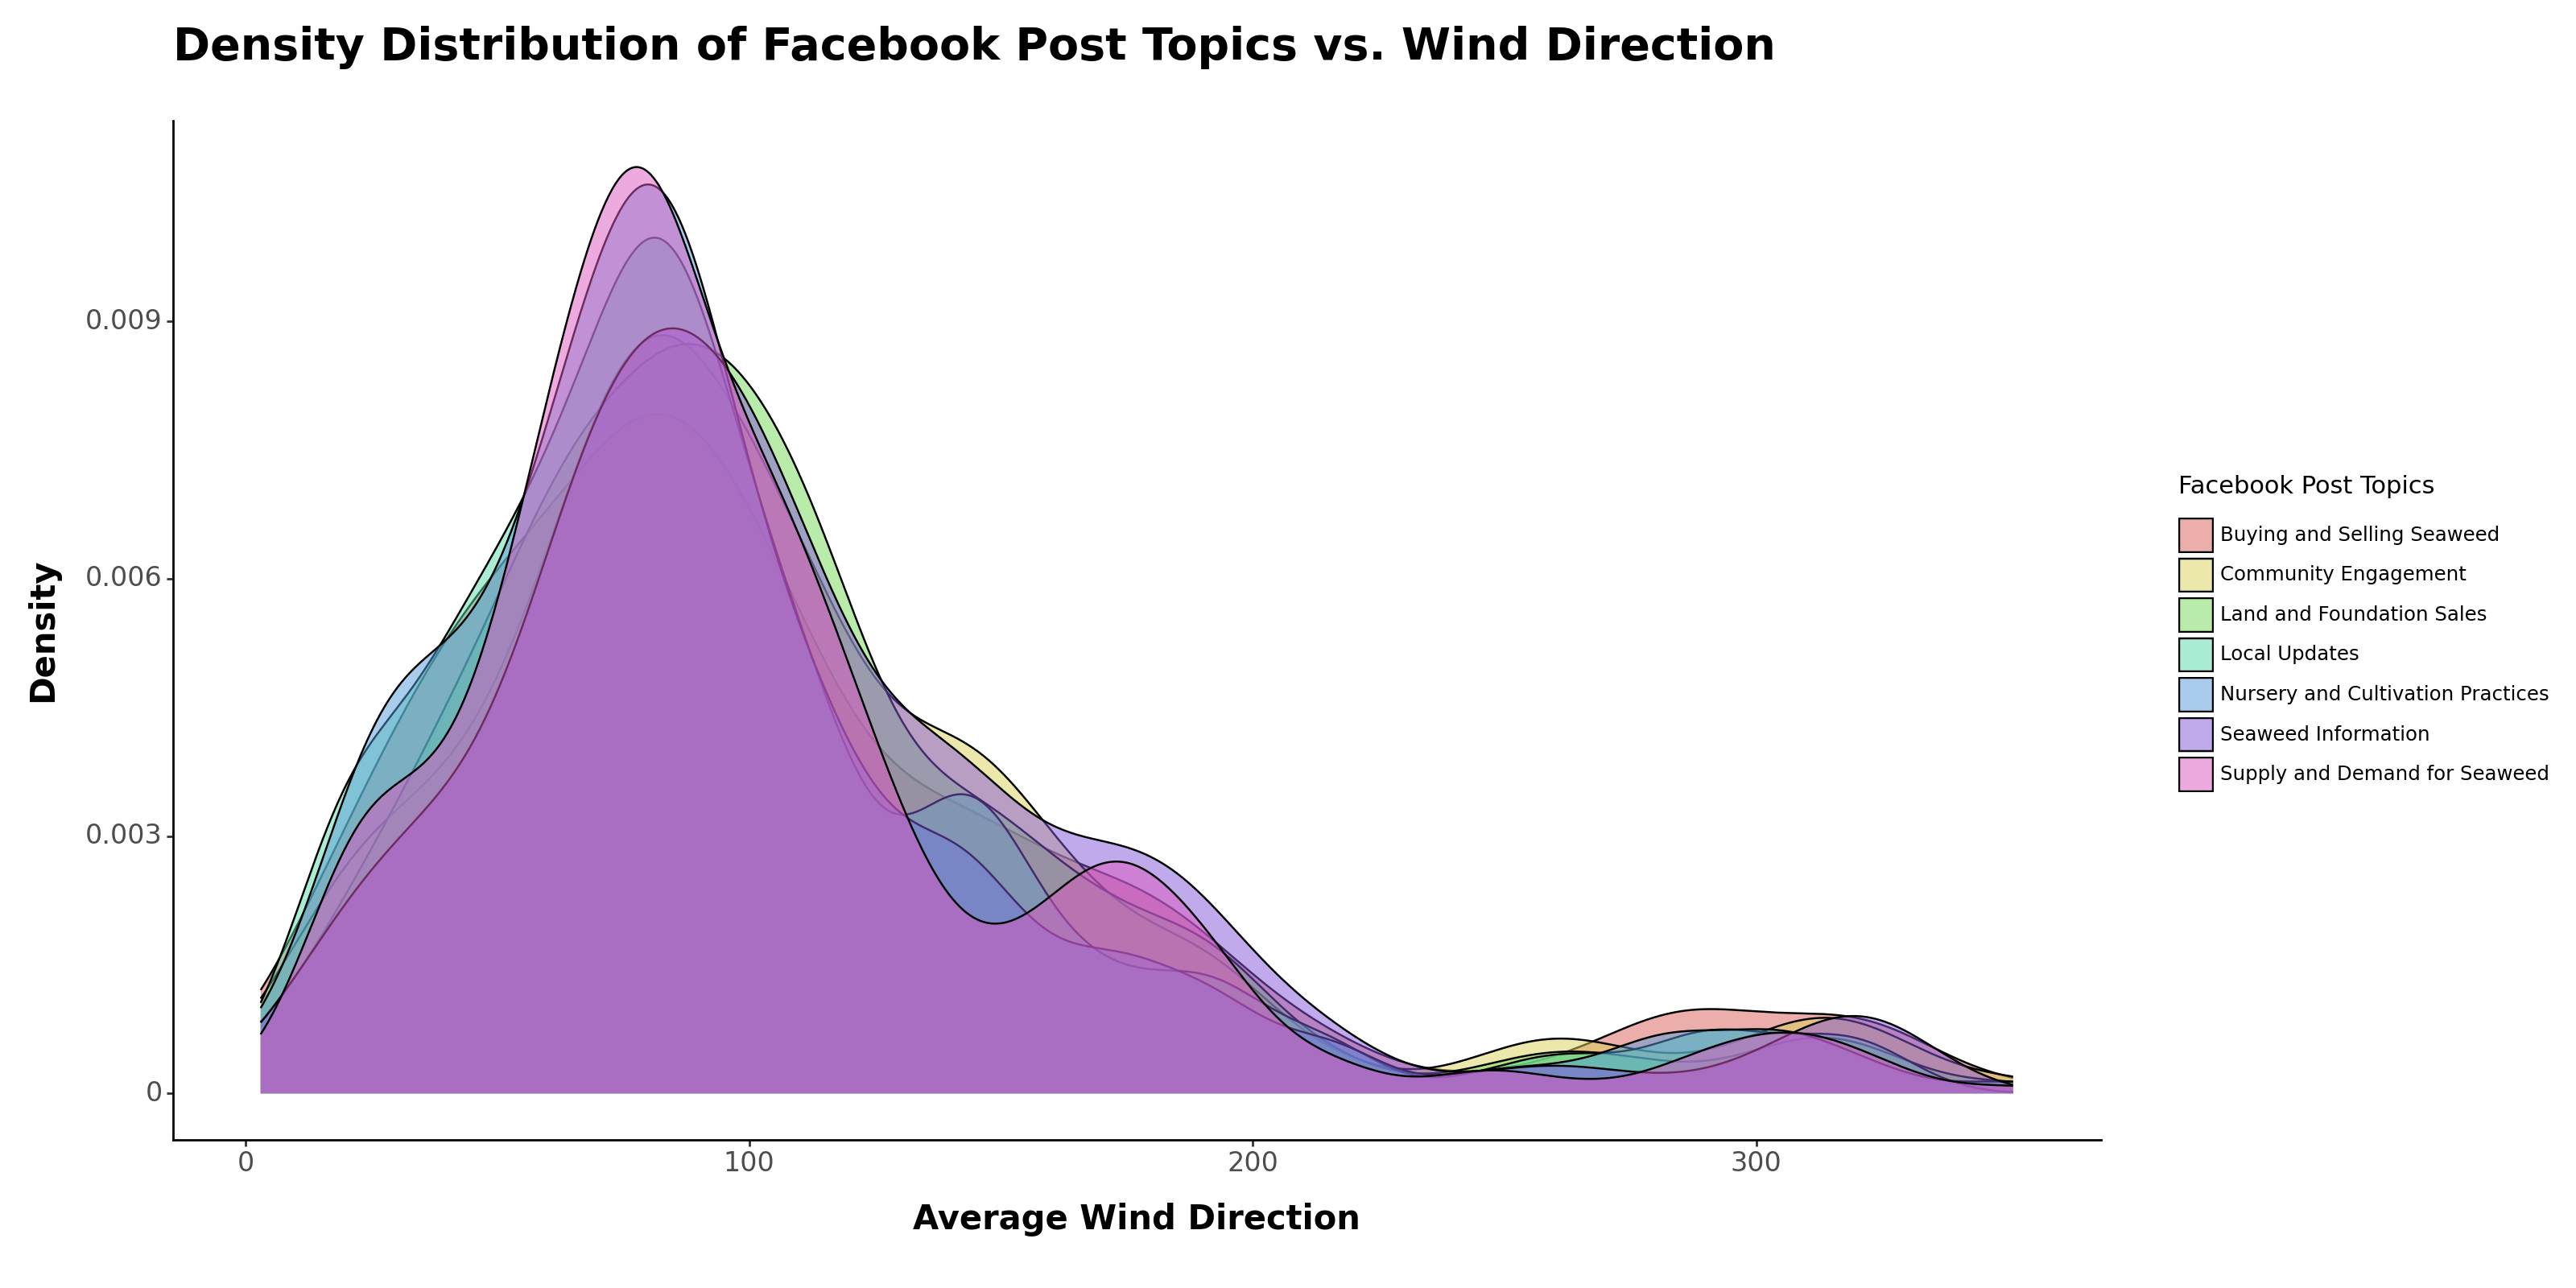

In [15]:


# Create the density plot with log-transformed x-axis
plot = (ggplot(joined_df, aes(x='wdir', fill='assigned_topic_name'))
        + geom_density(alpha=0.5)
        + labs(x="Average Wind Direction", y="Density", title="Density Distribution of Facebook Post Topics vs. Wind Direction", fill='Facebook Post Topics')
        # + scale_x_log10()  # Apply log10 transformation to x-axis
        + theme_classic()
        + theme(
            figure_size=(16, 8),  # Make the figure longer horizontally
            plot_title=element_text(size=20, weight='bold'),  # Adjust the title font size and boldness
            axis_title_x=element_text(size=15, weight='bold'),  # Adjust x-axis label font size and boldness
            axis_title_y=element_text(size=15, weight='bold'),  # Adjust y-axis label font size and boldness
            axis_text_x=element_text(size=12),  # Adjust x-axis ticks font size
            axis_text_y=element_text(size=12)   # Adjust y-axis ticks font size
        ))

print(plot)

The code below makes a word cloud of the different words that commonly appear in each cluster for greater visualization.

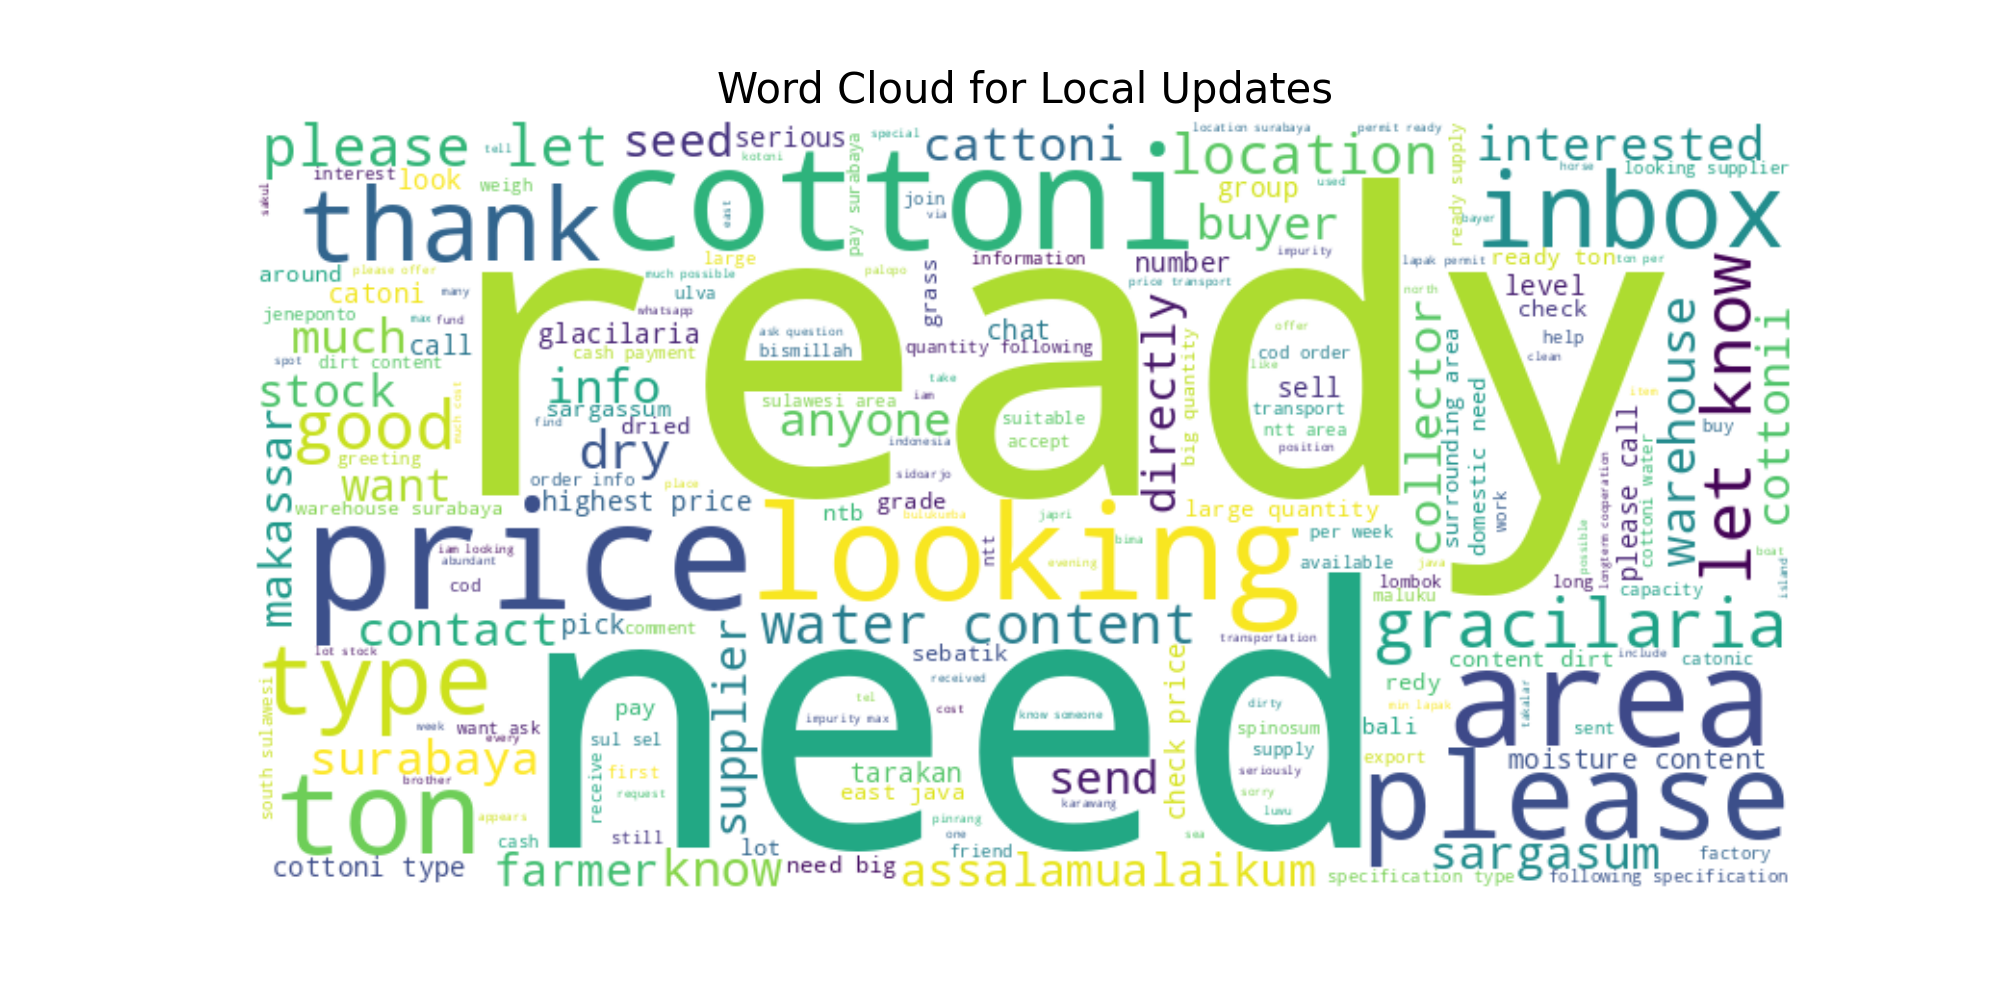

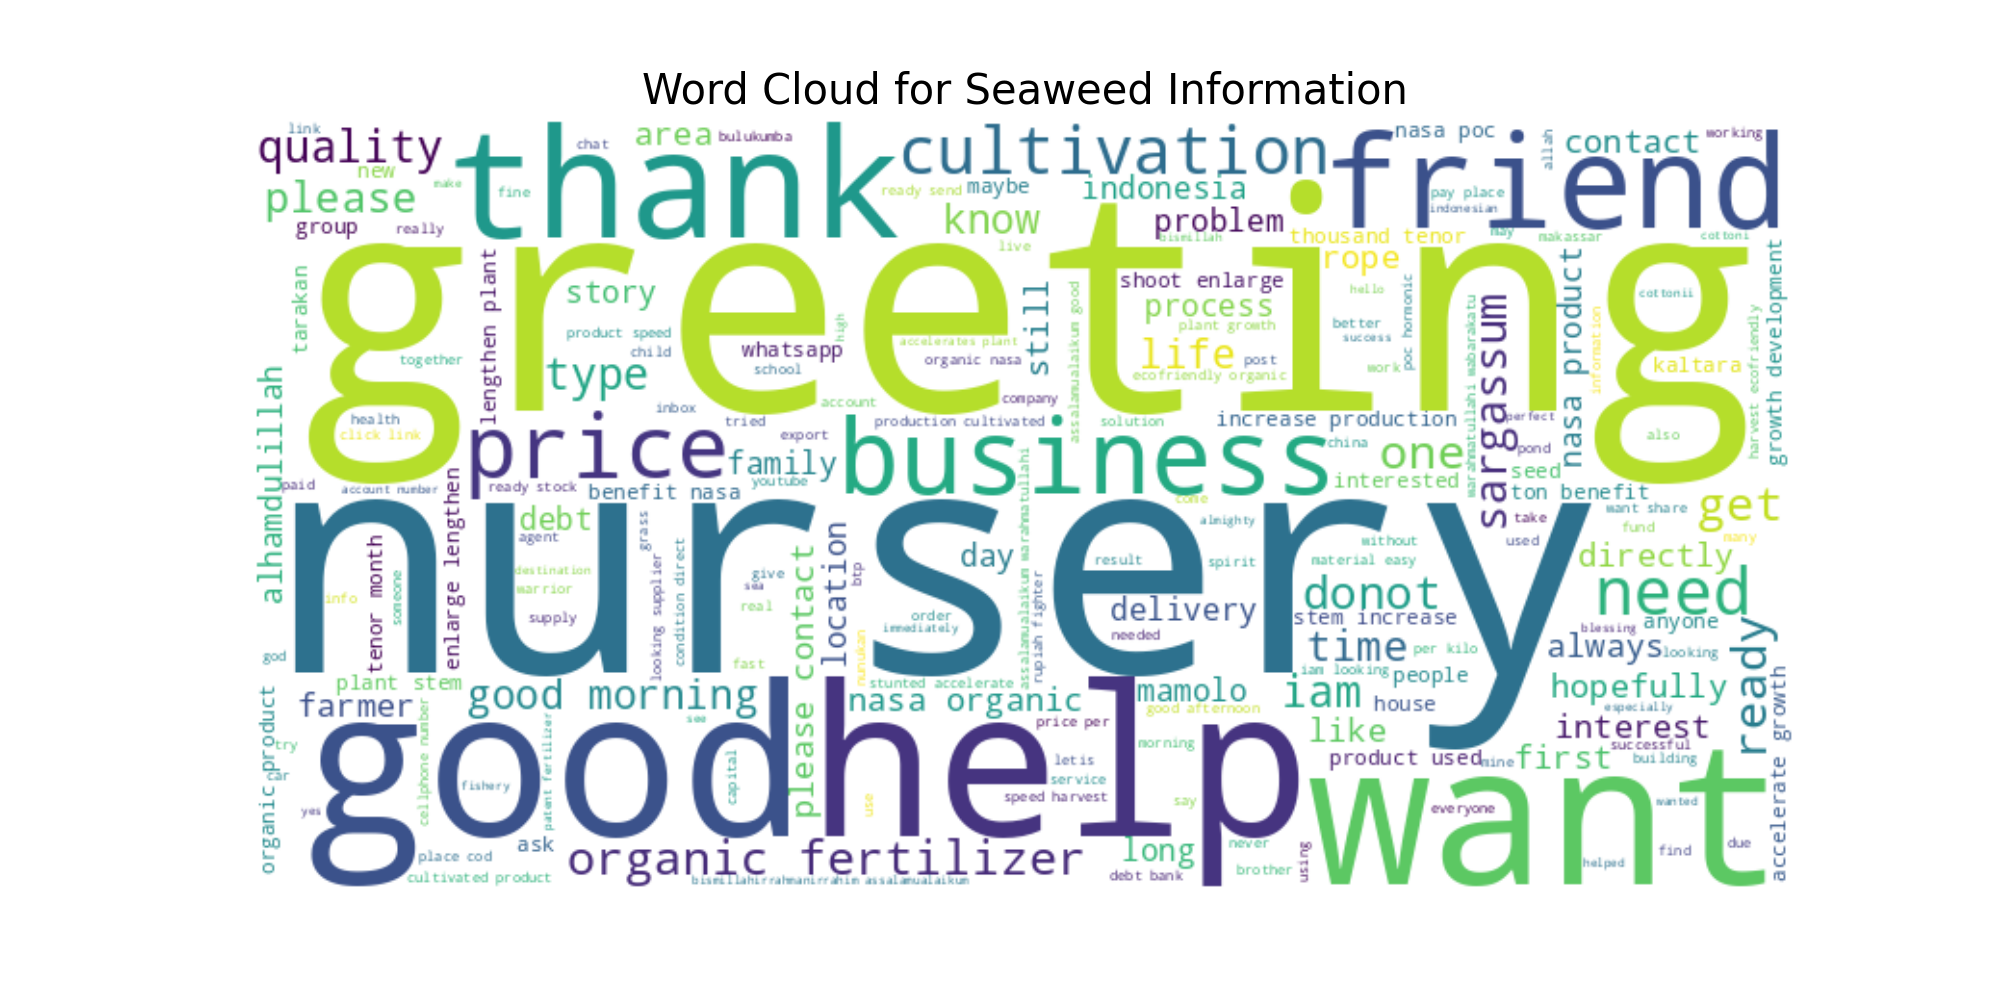

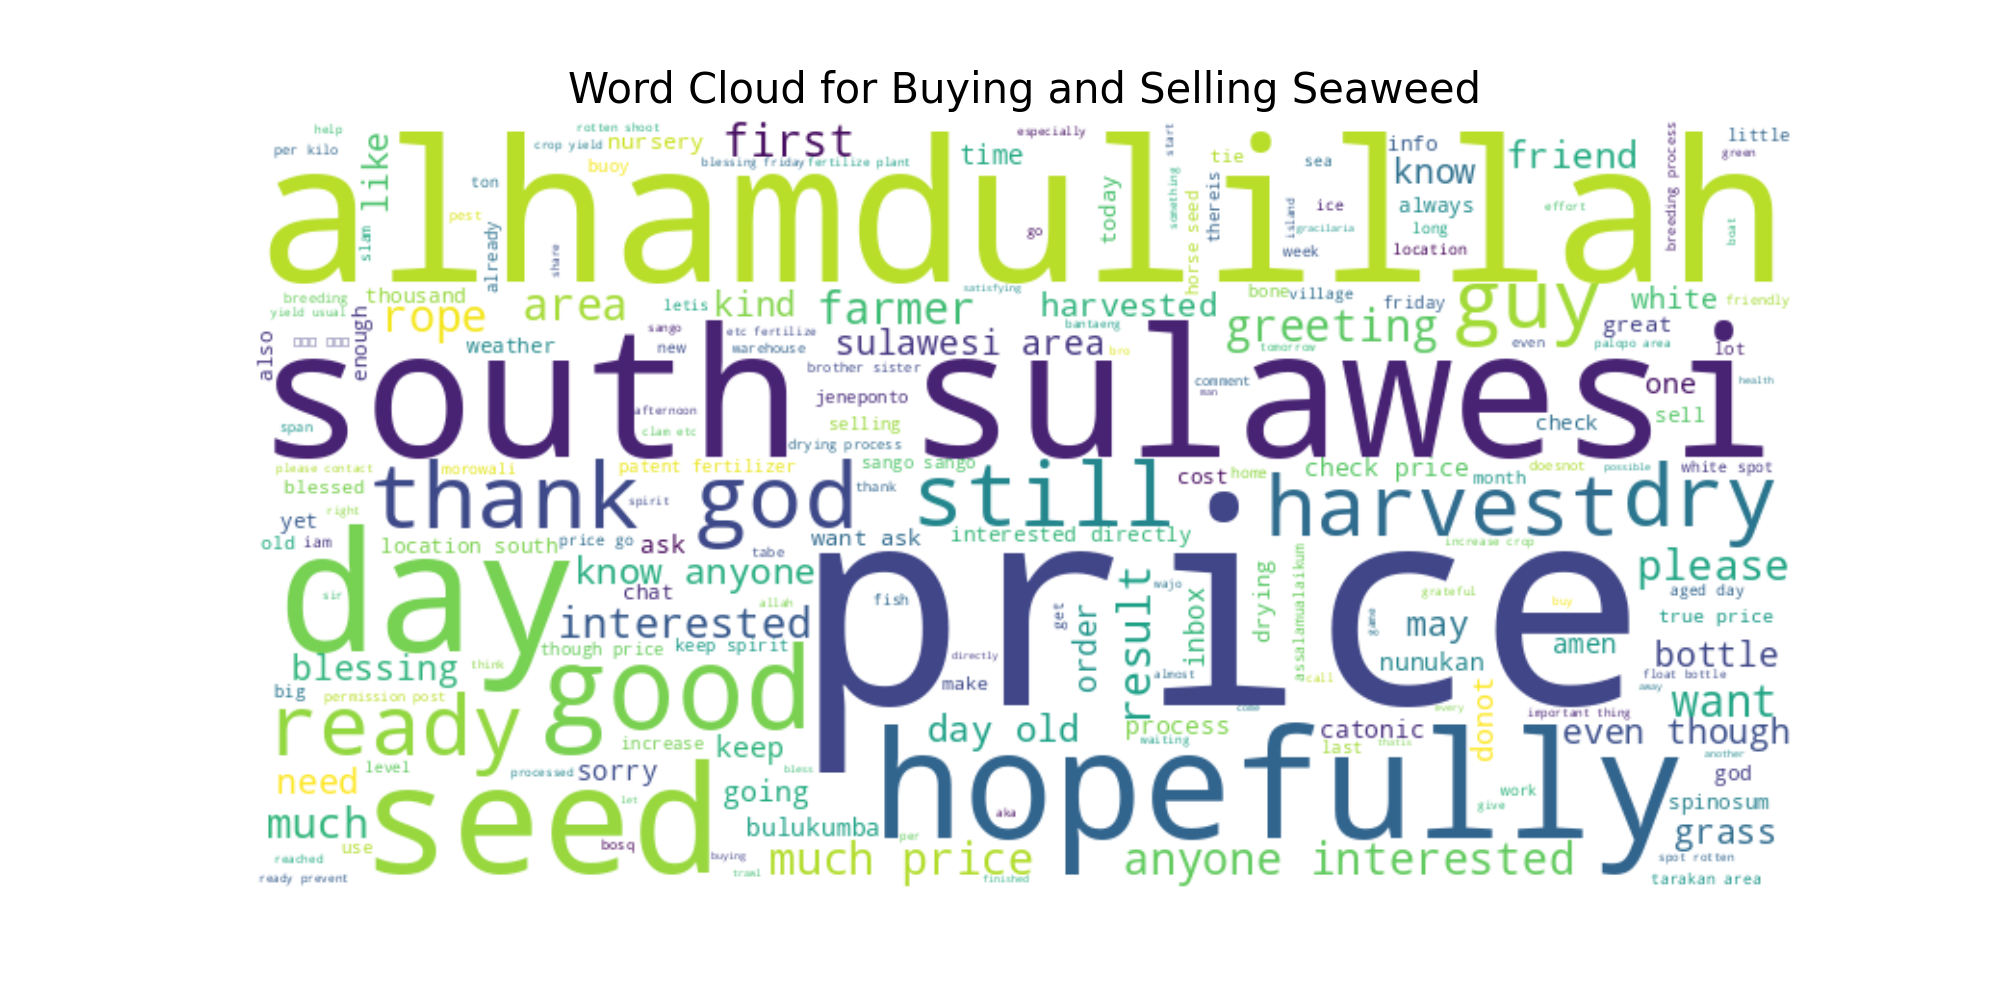

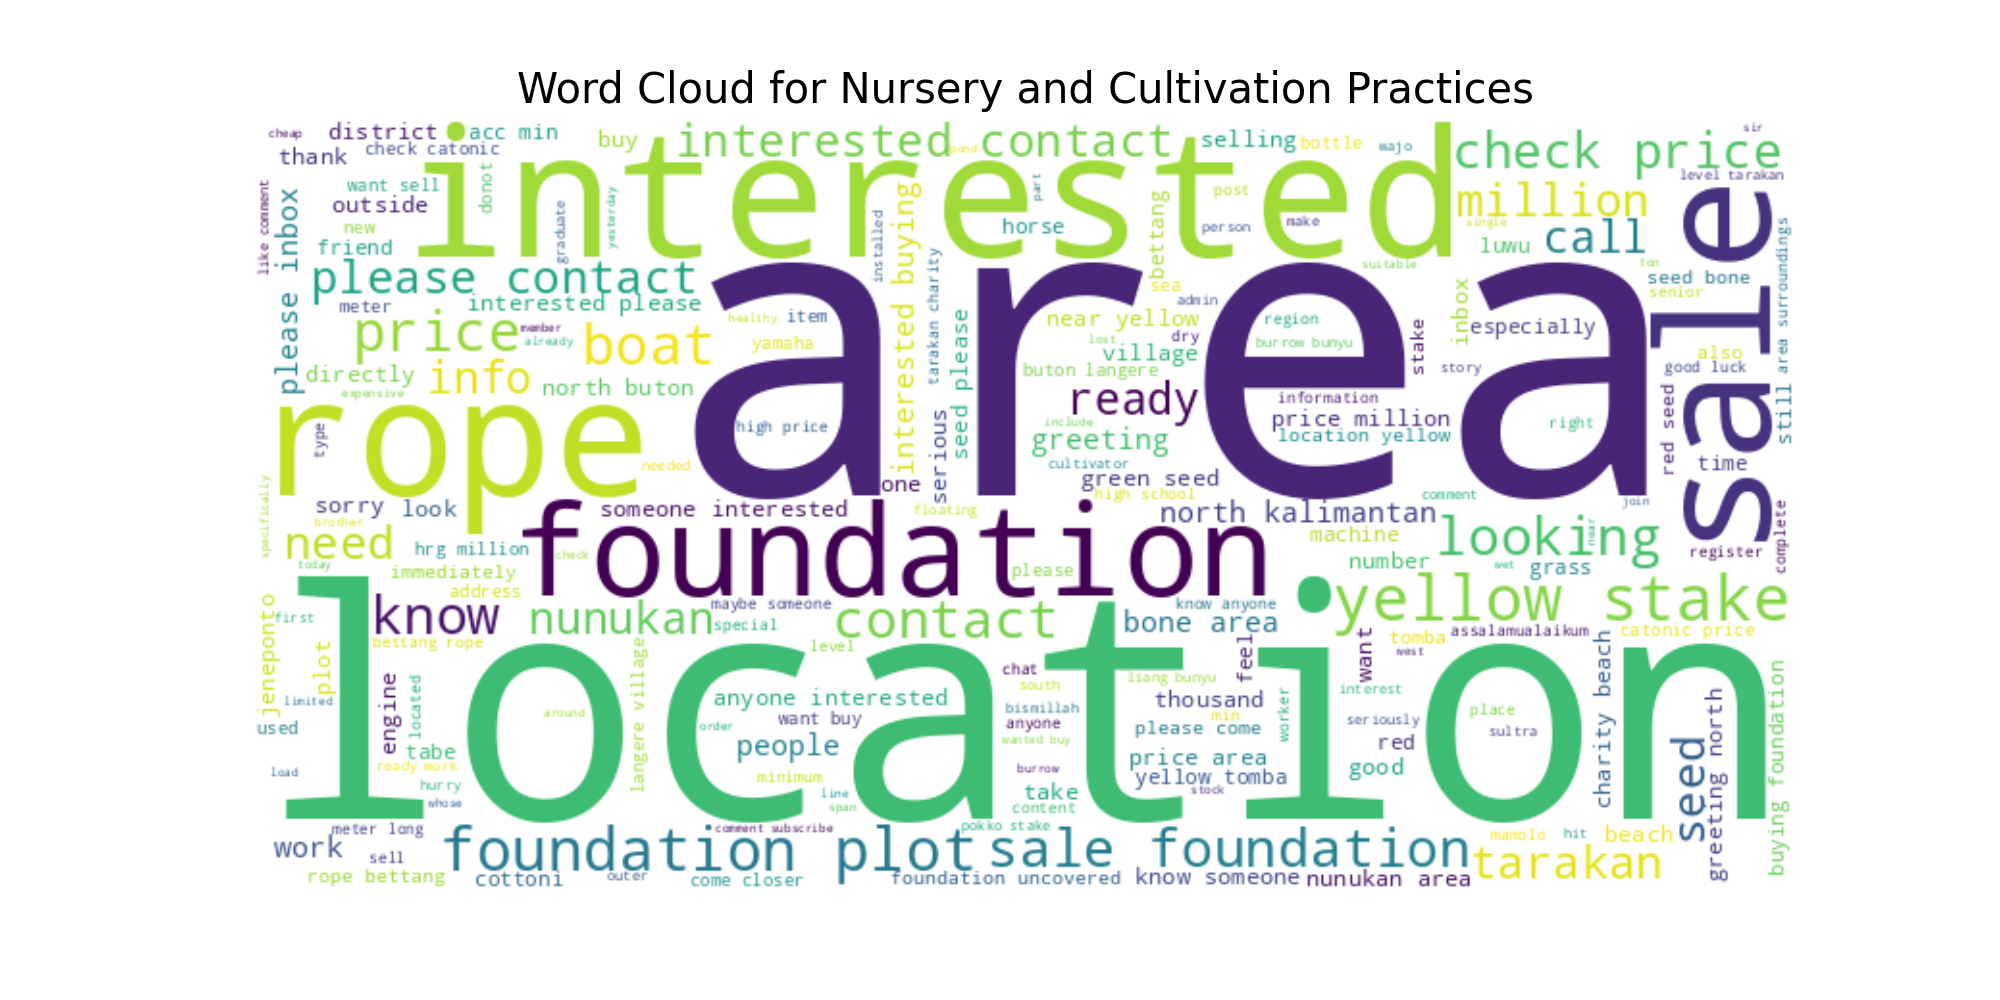

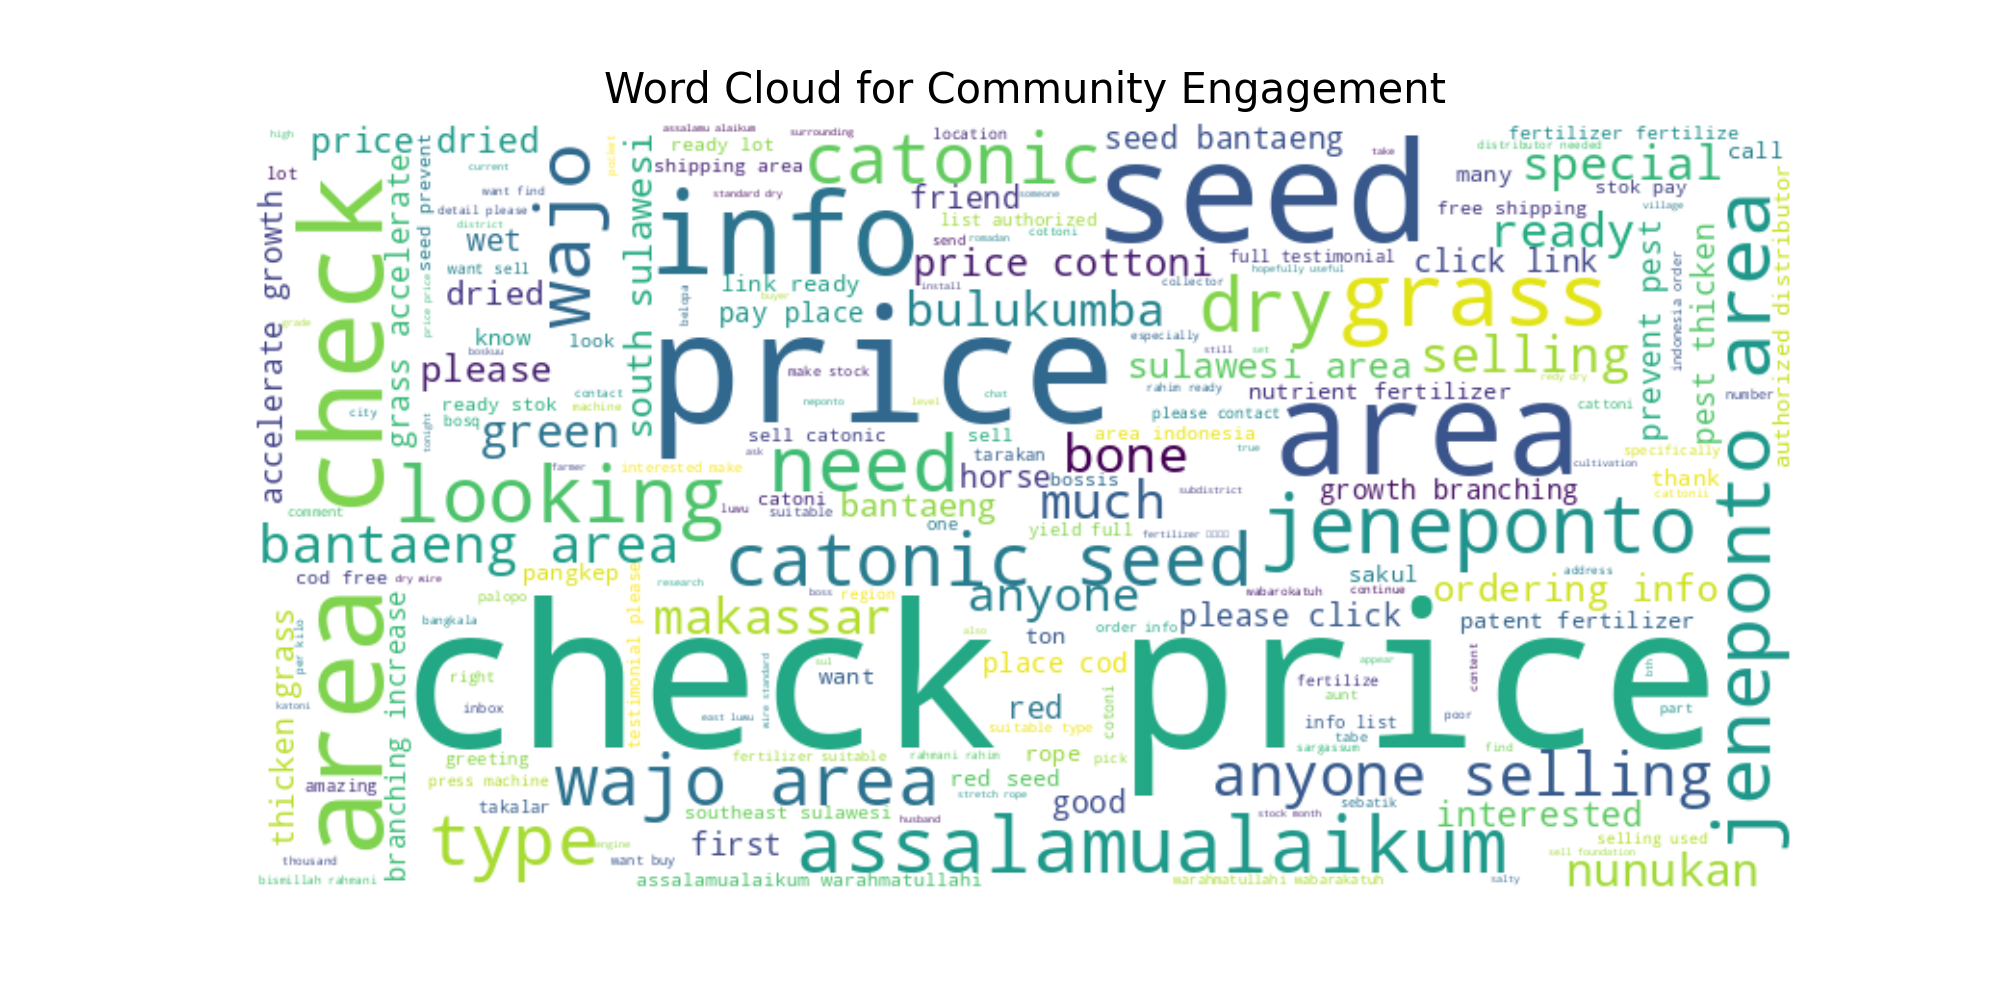

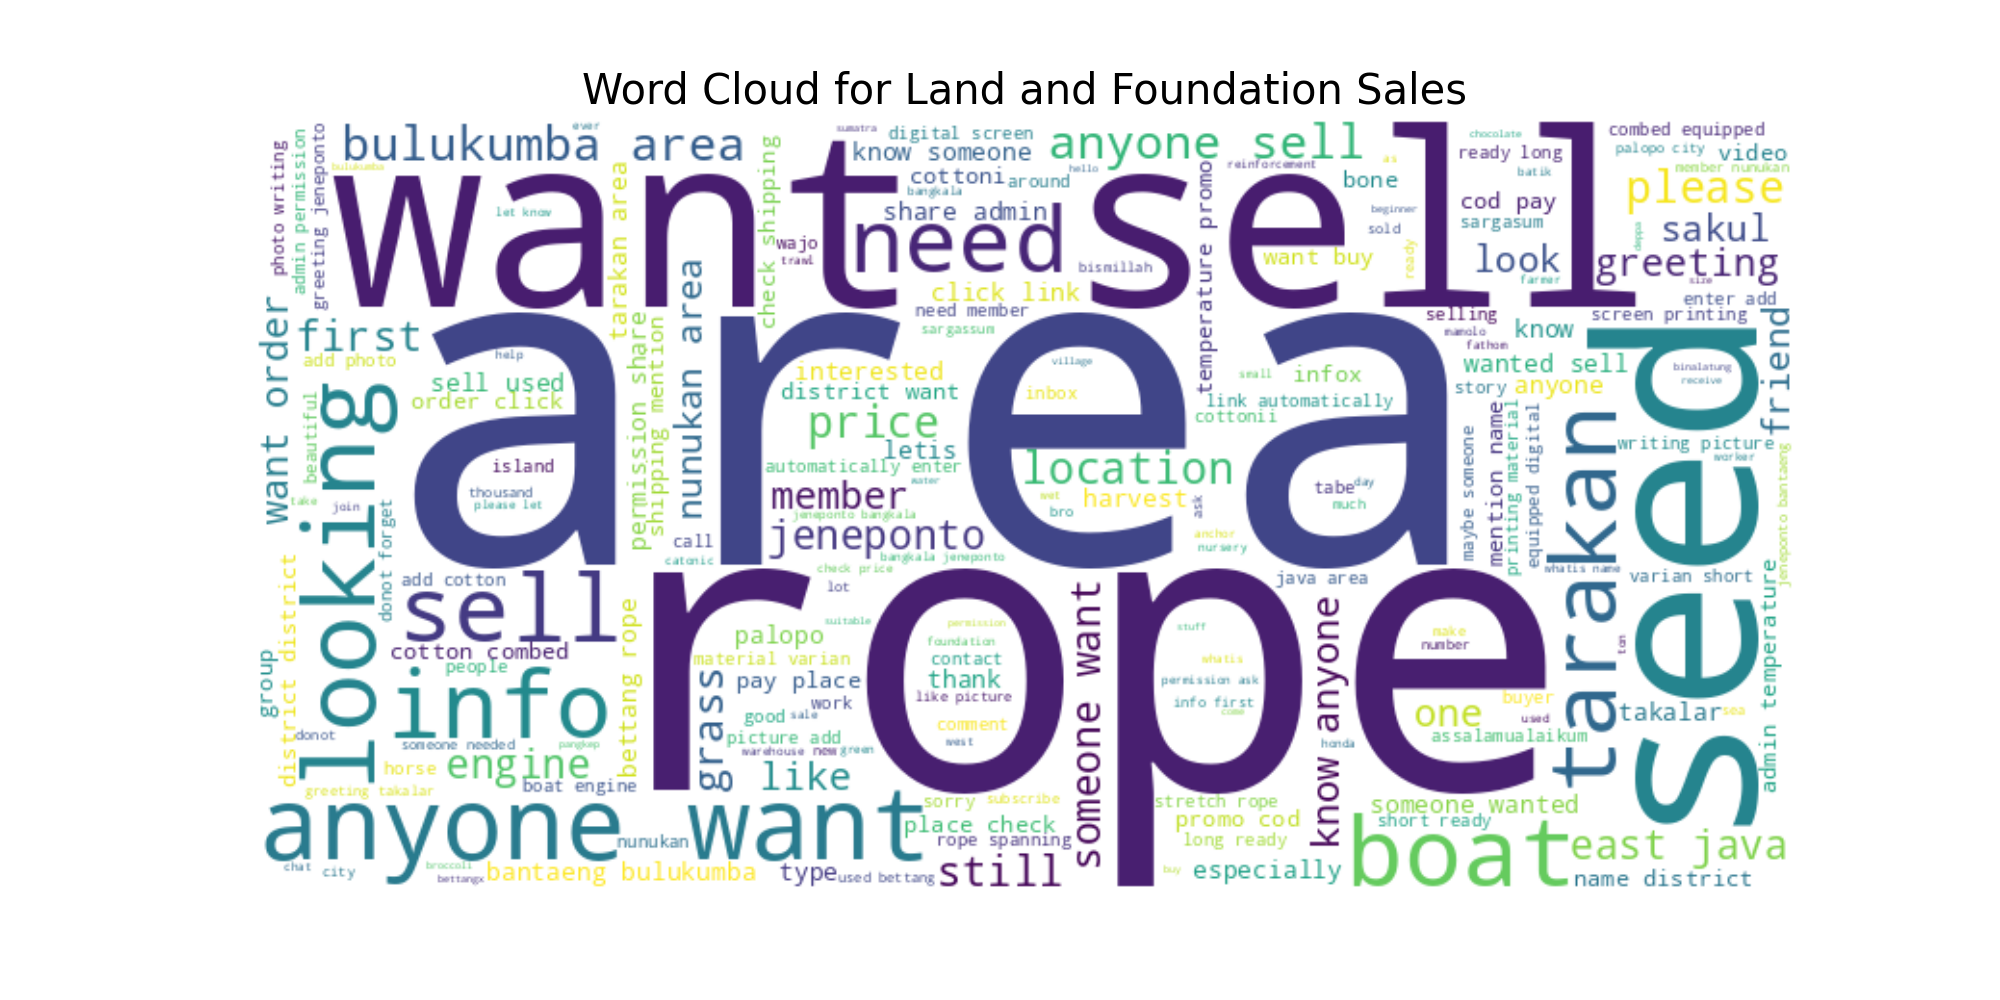

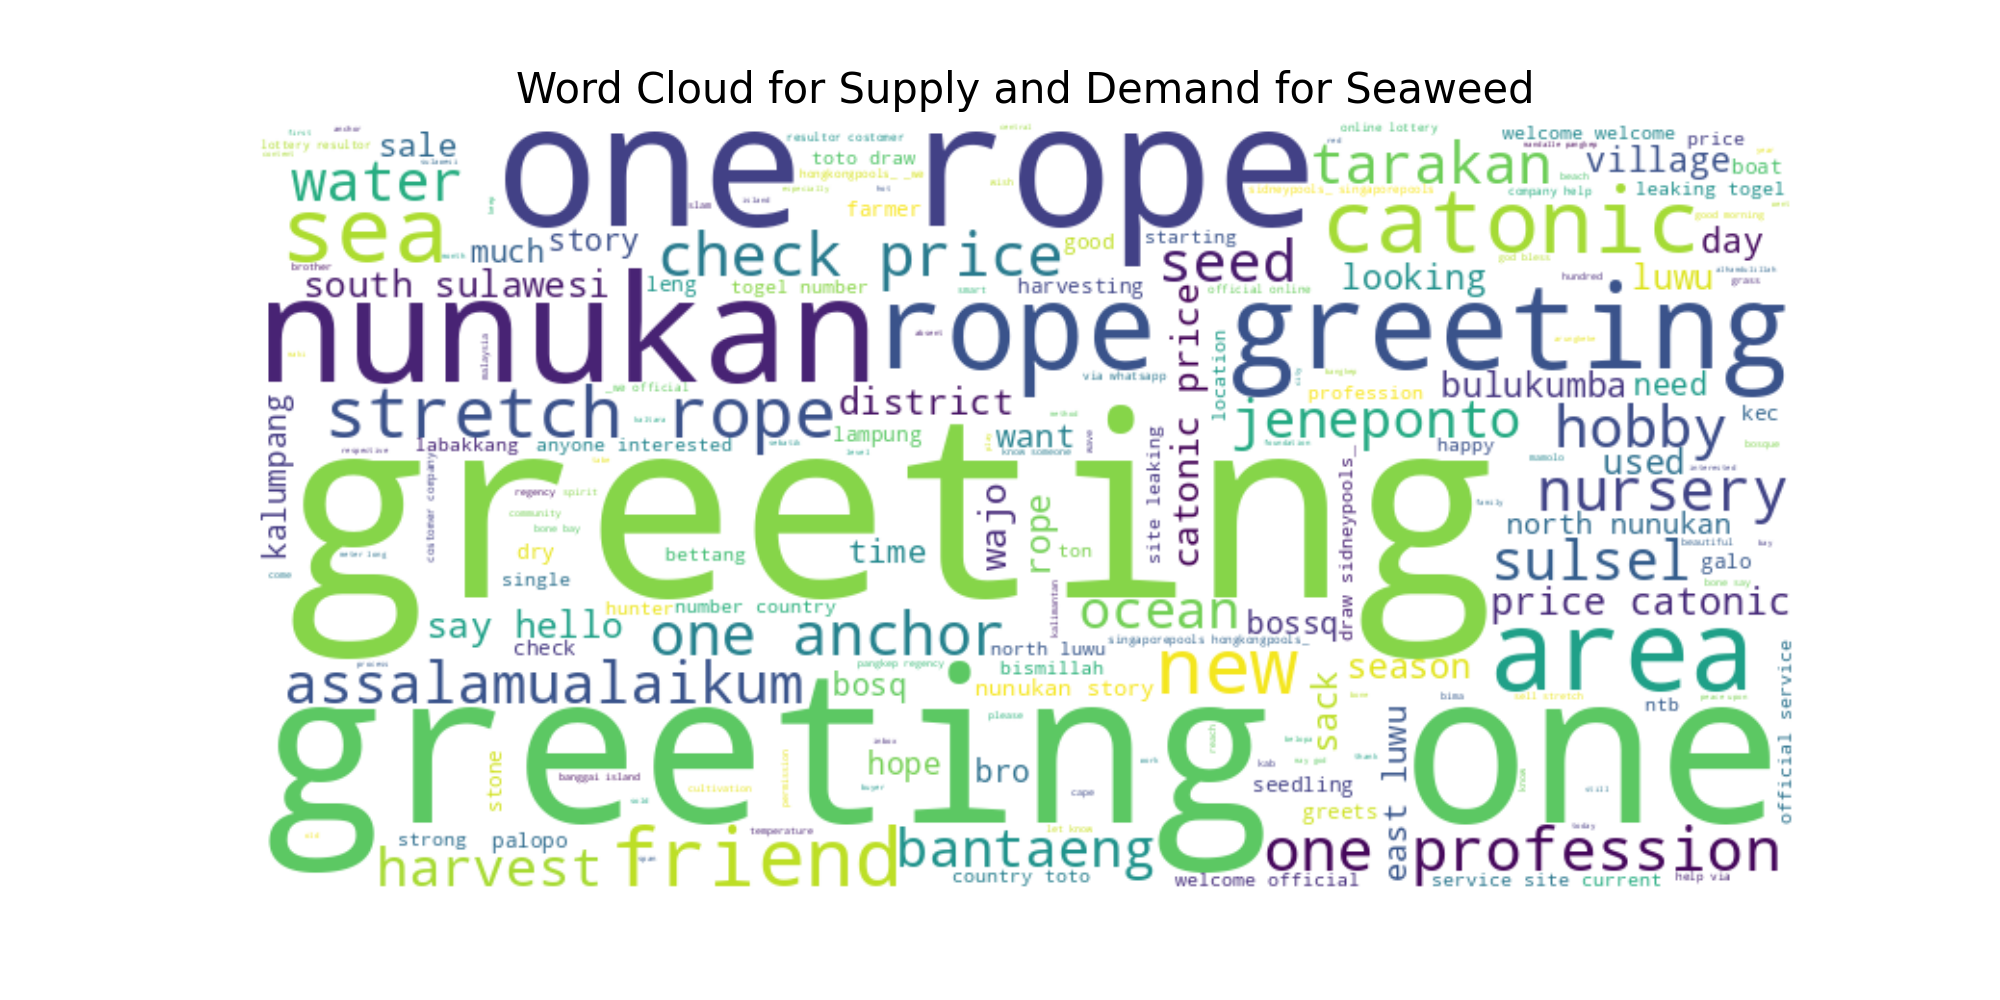

In [17]:
!pip install wordcloud

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate and display a word cloud
def generate_word_cloud(data, topic_name, additional_stopwords):
    if additional_stopwords is None:
        additional_stopwords = set()
    # Filter the DataFrame for the specified topic
    text = " ".join(post for post in data[data['assigned_topic_name'] == topic_name]['English'])

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=additional_stopwords).generate(text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {topic_name}", fontsize=15)
    plt.axis('off')
    plt.show()

# Additional stopwords to exclude the word "seaweed"
additional_stopwords = {'seaweed', "bos", "itis"}

# Generate word clouds for specified topics
topics = ["Local Updates", "Seaweed Information", "Buying and Selling Seaweed", "Nursery and Cultivation Practices", "Community Engagement", "Land and Foundation Sales", "Supply and Demand for Seaweed"]

for topic in topics:
    generate_word_cloud(joined_df, topic, additional_stopwords)

